# Курсовая работа
Выполнил: Валяев Георгий Анатольевич, ПИ20-6

In [132]:
from google.colab import drive

import pandas as pd
import numpy as np
import datetime, math, re

import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import anderson
from scipy.stats import kstest, norm, expon, weibull_min
from scipy.stats import chisquare, poisson

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from numpy.core.multiarray import result_type

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error

In [2]:
# для корректного отображения графиков
import plotly.io as pio
pio.renderers.default = "colab"

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Создание классов

### Класс датасета

In [136]:
class Dataset_roads(Dataset):
  '''
  Класс данных для обучения
  '''
  def __init__(self, data: pd.DataFrame, y: str, x: str = "time"):
    '''
    data: 
    '''
    self.X = torch.tensor(data[[x] + ["month:{}".format(i+1) for i in range(12)] + ["day:{}".format(i+1) for i in range(31)] + ["weekday:{}".format(i+1) for i in range(7)]].values, dtype=torch.float32)
    self.y = torch.tensor(data[y].values, dtype=torch.float32).view(-1, 1)
    
    X_mean = self.X.mean(dim=0)
    X_std = self.X.std(dim=0)
    self.X = (self.X - X_mean) / X_std

    Y_mean = self.y.mean(dim=0)
    Y_std = self.y.std(dim=0)
    self.y = (self.y - Y_mean) / Y_std

    self.X_mean = X_mean
    self.X_std = X_std
    self.Y_mean = Y_mean
    self.Y_std = Y_std

  def __len__(self):
    return self.y.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [137]:
class Dataset_roads_predict(Dataset):
  def __init__(self, data: pd.DataFrame, X_mean, X_std, x="time"):
    
    self.X = torch.tensor(data[[x] + ["month:{}".format(i+1) for i in range(12)] + ["day:{}".format(i+1) for i in range(31)] + ["weekday:{}".format(i+1) for i in range(7)]].values, dtype=torch.float32)

    self.X = (self.X - X_mean) / X_std
    self.X_mean = X_mean
    self.X_std = X_std
    self.indexes = data.index

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx]

### Класс модели

In [138]:
class Model:
    def __init__(self, dataframe: pd.DataFrame, TpCT: str):
      '''
      Инициализация
      :param dataframe: данные для построения обучения
      :type dataframe: pd.DataFrame
      :param TpCT: тип_автомобиля: направление_движения
      :type TpCT: str
      :returns: Параметры для предсказания 
      :rtype: pd.DataFrame
      '''
      self.TpCT = TpCT
      self.type = TpCT
      self.dataframe = dataframe
      self.dataset = None
      self.model = None
      self.train = None
      self.test = None
      self.optimizer = None
      self.criterion = None
      self.X_mean = None
      self.X_std = None
      self.Y_mean = None
      self.Y_std = None

      self.device = self.choose_device()
      self.create_dataset(self.dataframe)
      self.create_model()
      self.create_TestTrain()
      self.setOptimizer()
      self.setLossFunc()
    
    def __str__(self):
      return f"{self.type}"
    
    def choose_device(self):
      return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def create_model(self, model: torch.nn.Sequential=None, n1=100, n2=100, n3=125):
      if model is None:
        self.model = torch.nn.Sequential(
            torch.nn.Linear(51, n1),
            torch.nn.LayerNorm(n1),
            torch.nn.Softmax(),
            torch.nn.Linear(n1, n2),
            torch.nn.LayerNorm(n2),
            torch.nn.ReLU(),
            torch.nn.Linear(n2, n3),
            torch.nn.LayerNorm(n3),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(n3, 1)
            )
      else:
        self.model = model
      self.device = self.choose_device()
      self.model.to(self.device)

    def create_dataset(self, dataframe: pd.DataFrame):
      self.dataset = Dataset_roads(self.dataframe, y=self.TpCT)
      self.X_mean = self.dataset.X_mean
      self.X_std = self.dataset.X_std
      self.Y_mean = self.dataset.Y_mean
      self.Y_std = self.dataset.Y_std

    def create_TestTrain(self, split_percent: list=[0.8, 0.2]):
      self.train, self.test = torch.utils.data.random_split(self.dataset, split_percent)
    
    def setOptimizer(self, optimizer=None, **kwargs):
      if optimizer is None:
        param = {
            "lr": 0.05,
            **kwargs
        }
        self.optimizer = torch.optim.Adam(self.model.parameters(), **param)
      else:
        self.optimizer = optimizer(self.model.parameters(), **kwargs)
      return self.optimizer
      
    def setLossFunc(self, func=None, **kwargs):
      if func is None:
        param = {
            "reduction": "sum",
            **kwargs
        }
        self.criterion = torch.nn.MSELoss(**param)
      else:
        self.criterion = func(**kwargs)
      return self.criterion
      
    def train_model(self, epoch: int=1000, batch_size: int=256, shuffle: bool=True) -> list:
      '''
      Обучение модели
      :param epoch: количество эпох
      :type epoch: int

      :param batch_size: размер батча
      :type batch_size: int

      :param shuffle: флаг перемешивания данных в обучающем датасете
      :type shuffle: bool

      :returns: значение ошибки на протяжении обучения
      :rtype: list
      '''
      self.model.train()
      data_train_loader = DataLoader(self.train, batch_size=batch_size, shuffle=shuffle)
      train_losses = []
      for epoch_index in range(epoch):
        train_loss = 0
        for X, y in data_train_loader:
          self.optimizer.zero_grad()
          y_pred = self.model.forward(X)
          loss_val = self.criterion.forward(y_pred, y)
          loss_val.backward()

          train_loss += loss_val.item()
          self.optimizer.step()

        train_loss /= len(data_train_loader.dataset)
        train_losses.append(train_loss)

      return train_losses

    def dataset4predict(self, dataFrame: pd.DataFrame) -> Dataset_roads_predict:
      return Dataset_roads_predict(dataFrame, self.X_mean, self.X_std)

    def predict(self, dataframe: pd.DataFrame, batch_size: int=256, shuffle: bool=True) -> pd.DataFrame:
      '''
      Предсказание будущей интенсивности
      :param X: Данные для предсказания
      :type X: Dataset_roads_predict

      :param batch_size: размер батча
      :type batch_size: int

      :param shuffle: флаг перемешивания данных в обучающем датасете
      :type shuffle: bool

      :returns: Предсказанная интенсивность
      :rtype: pd.DataFrame
      '''
      self.model.eval()
      with torch.no_grad():
        dataset = self.dataset4predict(dataframe)
        y_pred = self.model.forward(dataset.X)
        Pr = torch.tensor(y_pred.view(1, -1)[0]).numpy()
        predict = (Pr * self.Y_std.numpy()) + self.Y_mean.numpy()
        result = pd.DataFrame(
          {
              "Prediction": predict
          }
        )
        result[result["Prediction"] < 0] = 0
        result = result.round({'Prediction': 0})
        result.index = dataframe.index

      return result

### Класс менеджера моделей

In [143]:
class ModelManager:
  def __init__(self, dataframe: pd.DataFrame):
    self.dataframe = dataframe
    self.types = [elem for elem in dataframe.columns[:18] if not elem.endswith('всего')]
    self.now_model = None
    self.lst_models = self.create_models()
    self.predict_data = pd.DataFrame()
  
  def get_models(self, lst_types):
    lst_models = []
    for mtype in lst_types:
      index_model = self.types.index(mtype)
      lst_models.append(self.lst_models[index_model])
    return lst_models

  def create_models(self):
    lst_models = []
    for mtype in self.types:
      model = Model(self.dataframe, mtype)
      lst_models.append(model)
    return lst_models
  
  def train_models(self):
    for model in self.lst_models:
      mtrain_losses = model.train_model()
      print(f'Модель признака «{model.TpCT}» успешно обучена!\nПервый Train Loss = {mtrain_losses[0]}, финальный Train Loss = {mtrain_losses[-1]}')
      print()

  def test_predict(self, type_model: str, batch_size=256, shuffle=True):
    index_model = self.types.index(type_model)
    self.now_model = self.lst_models[index_model]
    data_test_loader = DataLoader(self.now_model.test, batch_size=batch_size, shuffle=shuffle)

    self.now_model.device = self.now_model.choose_device()

    self.now_model.model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X, y in data_test_loader:
          X = X.to(self.now_model.device)
          y = y.to(self.now_model.device)

          y_pred_value = self.now_model.model.forward(X)

          y_true.extend(y.detach().cpu().tolist())
          y_pred.extend(y_pred_value.detach().cpu().tolist())

    r2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    MEDAE = median_absolute_error(y_true, y_pred)

    print(f'Test R2: {r2}')
    print(f'Test Mean Absolute Error: {MAE}')
    print(f'Test Mean Absolute Percentage Error: {round(MAPE, 4)}%')
    print(f'Test Mean Squared Error: {MSE}')
    print(f'Test Median Absolute Error: {MEDAE}')

    results_loss = pd.DataFrame({'True Value': sum(y_true, []), 'Prediction': sum(y_pred, [])})
    fig = px.line(results_loss)
    fig.show()
  
  def create_DataFrame_for_predict(self, prediction_duration: int=10) -> pd.DataFrame:

    '''
    Создание данных для предсказаний
    :param prediction_duration: Продолжительность предсказани в годах
    :type prediction_duration: int
    :returns: Параметры для предсказания 
    :rtype: pd.DataFrame
    '''
    start = self.dataframe.iloc[-1]["deta"] + pd.Timedelta("1 day")
    end = pd.to_datetime(datetime.datetime(start.year + prediction_duration, 1, 1)) + pd.Timedelta("-1 day")
    index = pd.date_range(start, end)

    df_pred = pd.DataFrame(columns=["deta", "time", "Month", "Day", "Weekday"])
    df_pred["deta"] = index
    df_pred.index = index
    df_pred["time"] = df_pred.index
    df_pred["time"] = df_pred["time"].apply(lambda x: x.value)
    df_pred["Month"] = df_pred['deta'].apply(lambda x: x.month)
    df_pred["Day"] = df_pred['deta'].apply(lambda x: x.day)
    df_pred["Weekday"] = df_pred['deta'].apply(lambda x: x.isoweekday())

    d = {"Month": "month:{}", "Day": "day:{}", "Weekday": "weekday:{}"}
    du = []
    for k, v in d.items():
      s = df_pred[k]
      du.append(pd.get_dummies(s))
      du[-1] = du[-1].rename({i+1: v.format(i+1) for i in range(du[-1].shape[1])}, axis=1)
    for i in du:
      df_pred = df_pred.join(i)
    
    return df_pred

  def make_prediction(self, type_model: str, prediction_duration: int=10) -> pd.DataFrame:
    '''
    Предсказание интннсивности на заданное количество лет
    :param type_model: тип модели (тип_автомобиля: направление_движения)
    :type type_model: str
    :param prediction_duration: на скольько лет предсказывать (по_умолчанию=10)
    :type prediction_duration: int
    :returns: Предсказанная интенсивность
    :rtype: pd.DataFrame
    '''
    index_model = self.types.index(type_model)
    self.now_model = self.lst_models[index_model]
    dataframe4predict = self.create_DataFrame_for_predict(prediction_duration)
    predict = self.now_model.predict(dataframe4predict)

    return predict

  def all_prediction(self) -> dict[list[pd.DataFrame, pd.DataFrame]]:
    '''
    Получение предсказаний от всех моделей
    :returns: словарь с типом авотмобилей в качестве ключа и списком с предсказанием интенсивности прямого и обратного движения
    :rtype: dict[list[pd.DataFrame, pd.DataFrame]]
    '''
    self.predict_data.drop(self.predict_data.index, inplace=True)
    for model_name in self.types:
      car_type, movement_direction = model_name.split(":")
      movement_direction = movement_direction.strip()
      
      predict = self.make_prediction(model_name)
      self.predict_data[model_name] = predict["Prediction"]

    self.predict_data.index = predict.index

    return self.predict_data

    # pred_dt = self.future_predict(type_model, 10)
    # results_all = pd.DataFrame({'Input Data': self.dataframe[type_model], 'Output Data': pred_dt['Prediction']})
    # results_all.index = real_dt.index.append(pred_dataset.index)
    # fig = px.line(results_all)
    # fig.show()
  
  def create_graphs(self, dataFrame: pd.DataFrame):
    fig = px.line(dataFrame)
    fig.show()
  
  def get_distribution_laws(self, column):

    data_analyze = self.dataframe[column]
    print(f"Анализируется датасет признака «{data_analyze.name}»...")
    print()

    # ------------ 1) Тест по критерию Харке-Бера ------------
    
    print("Тест по критерию Харке-Бера на нормальность:")
    print()

    statistics, p_value = stats.jarque_bera(data_analyze)
    
    # Вывести результаты теста
    print("Статистика Харке-Бера:", statistics)
    print("P-значение:", p_value)
    print()
    if p_value > 0.05:
        print("Выборка соответствует нормальному распределению")
    else:
        print("Выборка не соответствует нормальному распределению")
    
    print()

    # ------------ 2) Тест по критерию Андерсона-Дарлинга ------------

    print("Тест по критерию Андерсона-Дарлинга на логистичность:")
    print()

    # Проводим тест Андерсона-Дарлинга с помощью функции anderson()
    # Второй параметр - выбранное распределение для сравнения. 
    # Третий параметр - тип распределения.
    result = anderson(data_analyze, dist='logistic')
    p_value = result[1][2]
    
    # Вывести результаты теста
    print("Статистика Андерсона-Дарлинга:", result.statistic)
    print("P-значение:", p_value)
    print()
    if p_value > result.statistic:
        print("Выборка соответствует логистическому распределению")
    else:
        print("Выборка не соответствует логистическому распределению")
    
    print()

    # ------------ 3) Тест по критерию Колмогорова-Смирнова ------------

    print("Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:")
    print()

    # Оцениваем параметры распределения, наилучшим образом описывающего нашу выборку данных
    mu, std = norm.fit(data_analyze)

    # Оцениваем соответствие выборки распределению нормального закона
    D, p_value = kstest(data_analyze, 'norm', args=(mu, std))

    # Вывести результаты теста
    alpha = 0.05
    print("Статистика Колмогорова-Смирнова:", D)
    print("P-значение:", p_value)
    print()
    if p_value > alpha:
        print("Выборка соответствует нормальному распределению")
    else:
        print("Выборка не соответствует нормальному распределению")
    
    print()
    print()

    mu, std = expon.fit(data_analyze)

    # Проверить выборку на соответствие экспоненциальному распределению
    statistic, p_value = kstest(data_analyze, 'expon', args=(mu, std))

    # Вывести результаты теста
    alpha = 0.05
    print("Статистика Колмогорова-Смирнова:", statistic)
    print("P-значение:", p_value)
    print()
    if p_value > alpha:
        print("Выборка соответствует экспоненциальному распределению")
    else:
        print("Выборка не соответствует экспоненциальному распределению")
    
    print()
    print()

    # Вычисление параметров распределения Вейбулла по выборке данных
    shape, loc, scale = weibull_min.fit(data_analyze, floc=0)

    # Проверка выборки данных на принадлежность распределению Вейбулла с помощью критерия Колмогорова-Смирнова
    test_statistic, p_value = kstest(data_analyze, 'weibull_min', args=(shape, loc, scale))

    # Вывести результаты теста
    alpha = 0.05
    print("Статистика Колмогорова-Смирнова:", test_statistic)
    print("P-значение:", p_value)
    print()
    if p_value > alpha:
        print("Выборка соответствует распределению Вейбулла")
    else:
        print("Выборка не соответствует распределению Вейбулла")
    
    print()

    # ------------ 4) Тест по хи-квадрат ------------

    print()
    # Создаем выборку
    lam = int(data_analyze.mean())
    sample = data_analyze

    # Вычисляем наблюдаемые частоты
    observed_freq, _ = np.histogram(sample, bins=np.arange(sample.max() + 2))

    # Вычисляем ожидаемые частоты
    expected_freq = poisson.pmf(range(sample.max() + 1), lam) * len(sample)

    # Применяем критерий хи-квадрат
    _, p_value = chisquare(observed_freq, expected_freq)

    # Выводим результат
    if p_value < 0.05:
        print("Распределение не соответствует закону Пуассона")
    else:
        print("Распределение соответствует закону Пуассона")

    print()

    # ------------ 5) Отображение гистограмм ------------

    data = data_analyze.to_numpy(dtype=int)
    x = np.linspace(min(data), max(data), 100)

    plt.hist(data, density=True, alpha=0.6, label='Интенсивность')
    plt.suptitle(f"Датасет признака «{data_analyze.name}»")
    plt.legend()
    plt.show()

    # Проверка на нормальность и экспоненциальность, а также на распределение Вейбулла
    normal = stats.norm.fit(data)
    gammal = stats.gamma.fit(data)
    exponen = stats.expon.fit(data)
    weibull = stats.weibull_min.fit(data)
    laplacel = stats.laplace.fit(data)
    betal = stats.beta.fit(data)

    # Сравние полученных распределений с данными, используя критерий согласия Колмогорова-Смирнова
    norm_test = stats.kstest(data, 'norm', args=normal)
    gamma_test = stats.kstest(data, 'gamma', args=gammal)
    expon_test = stats.kstest(data, 'expon', args=exponen)
    weibull_test = stats.kstest(data, 'weibull_min', args=weibull)
    laplace_test = stats.kstest(data, 'laplace', args=laplacel)
    beta_test = stats.kstest(data, 'beta', args=betal)

    # Выбираем распределение, близкое к распределению наших данных

    if (norm_test[1] > expon_test[1]) and (norm_test[1] > weibull_test[1]) and (norm_test[1] > gamma_test[1]) and (norm_test[1] > laplace_test[1]) and (norm_test[1] > beta_test[1]):
      best_fit = 'Нормальное'
    elif (weibull_test[1] > expon_test[1]) and (weibull_test[1] > norm_test[1]) and (weibull_test[1] > gamma_test[1]) and (weibull_test[1] > laplace_test[1]) and (weibull_test[1] > beta_test[1]):
      best_fit = 'Распределение Вейбулла'
    elif (gamma_test[1] > expon_test[1]) and (gamma_test[1] > weibull_test[1]) and (gamma_test[1] > norm_test[1]) and (gamma_test[1] > laplace_test[1]) and (gamma_test[1] > beta_test[1]):
      best_fit = 'Гамма-распределение'
    elif (laplace_test[1] > expon_test[1]) and (laplace_test[1] > norm_test[1]) and (laplace_test[1] > gamma_test[1]) and (laplace_test[1] > weibull_test[1]) and (laplace_test[1] > beta_test[1]):
      best_fit = 'Распределение Лапласа'
    elif (beta_test[1] > expon_test[1]) and (beta_test[1] > norm_test[1]) and (beta_test[1] > gamma_test[1]) and (beta_test[1] > weibull_test[1]) and (beta_test[1] > laplace_test[1]):
      best_fit = 'Бета-распределение'
    else:
      best_fit = 'Экспоненциальное'
    print(f"Близкое распределение к нашим данным: {best_fit}")
    
    # Визуализация
    plt.hist(data, density=True, alpha=0.6, label='Интенсивность')

    pdf_normal = stats.norm.pdf(x, *normal)
    plt.plot(x, pdf_normal, label='Normal')

    pdf_gamma = stats.gamma.pdf(x, *gammal)
    plt.plot(x, pdf_gamma, label='Gamma')

    pdf_exponential = stats.expon.pdf(x, *exponen)
    plt.plot(x, pdf_exponential, label='Exponential')

    pdf_weibull = stats.weibull_min.pdf(x, *weibull)
    plt.plot(x, pdf_weibull, label='Weibull')

    pdf_laplace = stats.laplace.pdf(x, *laplacel)
    plt.plot(x, pdf_laplace, label='Laplace')

    pdf_beta = stats.beta.pdf(x, *betal)
    plt.plot(x, pdf_beta, label='Beta')

    plt.suptitle(f"Датасет признака «{data_analyze.name}»")
    plt.legend()
    plt.show()
  
  def forecast_road_roughness(self, data: pd.DataFrame,
                              IRI: str = "IRI.xlsx",
                              IRI_read_opt: dict = {"header": None, "skiprows": 5},
                              r_max: int = 15):
    
    '''
    Нахождение прогнозируемых значения продольной ровности по годам эксплуатации на перспективу N лет для каждой полосы движения

    :param data: данные с предсказаниями интенсивности
    :param IRI: данные с фактической ровностью
    :param r_max: максимально допустимый процент протяженности участка с критическим значением показателя продольной ровности в процентах
    (принимается в соответствии с договорными и гарантийными обязательствами)

    :returns: Предсказанная интенсивность
    :rtype: pd.DataFrame
    '''

    def days_in_year(x):
      day1 = x.replace(day=1, month=1)
      day2 = day1.replace(year=day1.year+1)
      return (day2 - day1).days

    def list_ch(list_names: list, re_s: str, incl: bool =True):
      '''вернет список с значениями в которых есть(или нет) re_s подстроки'''
      if incl:
        return [ct for ct in list_names if re.search(re_s, ct) is not None]
      else:
        return [ct for ct in list_names if re.search(re_s, ct) is None]

    car_and_move_type = [
        'легковые: прямое', 'легковые: обратное', 
        'микроавтобусы, малые грузовики: прямое', 
        'микроавтобусы, малые грузовики: обратное',
        'одиночные АТС, автобусы: прямое', 'одиночные АТС, автобусы: обратное',
        'автопоезда до 13 м: прямое', 'автопоезда до 13 м: обратное',
        'автопоезда 13..18  м: прямое', 'автопоезда 13..18  м: обратное']
    pass_car_move = list_ch(car_and_move_type, "легковые", incl=True)
    not_pass_car_move = [ct for ct in car_and_move_type if ct not in pass_car_move]

    # Процент недопустимой протяженности участка с критическим значением ровности
    r_NeDop = 1 + r_max

    # Загрузка данных  IRI
    if type(IRI) == str:
      IRI = pd.read_excel(IRI, **IRI_read_opt)
      names = ["Начало участка","Конец участка", "Прямое напр(1)","Прямое напр(2)",
          "Обратное напр(1)", "Обратное напр(2)","Прибор","Нормальное знач"]
      IRI.columns = names
      IRI.set_index("Начало участка", inplace=True)
    
    # return IRI
    
    # Отсортируем значения в порядке возрастания
    direction={"Прямое": 2, "Обратное": 2}
    ranked_row = pd.DataFrame()

    for direct in ["Прямое", "Обратное"]:
      for line in range(1, direction[direct]+1):
        name = f"{direct} напр({line})"
        column = IRI[name].sort_values(ascending= False).to_frame()

        ranked_row[name] = column
        ranked_row[f"{name} Участок"] = column.index
    ranked_row.index = list(range(1,IRI.shape[0]+1))

    # return ranked_row

    # Определяем порядковый номер измерения, соответствующего критическому проценту деформированной поверхности
    N = ranked_row.shape[0] # Количество измеренныых участков (значений ранжированного ряда)
    n = int((N*r_NeDop)/100)

    # return n

    IRI_f = ranked_row.loc[n]
    IRI_f = IRI_f.to_frame()

    # return IRI_f

    # Расчет IRI_f по годам

    data["Month"] = data.index.map(lambda x: x.month)
    data["Year"] = data.index.map(lambda x: x.year)

    # return data

    # Сумма прошедших автомобилей за год
    N_sum_y = data.groupby("Year").sum() # Сумма за год
    N_sum_y = N_sum_y[car_and_move_type]

    # return N_sum_y

    N_sum_y["Легковые прямое"] = N_sum_y[list_ch(pass_car_move, "прямое")].sum(axis=1)
    N_sum_y["Легковые обратное"] = N_sum_y[list_ch(pass_car_move, "обратное")].sum(axis=1)

    N_sum_y["Не легковые прямое"] = N_sum_y[list_ch(not_pass_car_move, "прямое")].sum(axis=1)
    N_sum_y["Не легковые обратное"] = N_sum_y[list_ch(not_pass_car_move, "обратное")].sum(axis=1)
    
    sum_column_name = ["Легковые прямое", "Легковые обратное", "Не легковые прямое", "Не легковые обратное"]

    day_in_year = N_sum_y.index.map(lambda x: 366 if pd.Period(f'{x}-01-01').is_leap_year else 365)
    N_sum_y["Всего прямое"] = N_sum_y[list_ch(car_and_move_type, "прямое")].sum(axis=1)
    N_sum_y["Всего обратное"] = N_sum_y[list_ch(car_and_move_type, "обратное")].sum(axis=1)
    
    N_sum_y["Ср.инт прямое"] = N_sum_y["Всего прямое"]/day_in_year # Среднегодовая суточная интенсивность прямого
    N_sum_y["Ср.инт обратное"] = N_sum_y["Всего обратное"]/day_in_year # Среднегодовая суточная интенсивность обратного

    N_sum_y["Расч.инт. прямое"] = N_sum_y["Ср.инт прямое"]*0.076 # Часовая расчетная интенсивность прямое
    N_sum_y["Расч.инт. обратное"] = N_sum_y["Ср.инт обратное"]*0.076 # Часовая расчетная интенсивность обратное

    N_sum_y["Соотн. прямое"] = N_sum_y["Не легковые прямое"]/N_sum_y["Всего прямое"] # Доля не легковых автомобилей в потоке
    N_sum_y["Соотн. обратное"] =  N_sum_y["Не легковые обратное"]/N_sum_y["Всего обратное"] # Доля не легковых автомобилей в потоке

    # return N_sum_y[list_ch(N_sum_y.columns, ":", incl=False)]

    share = pd.read_excel(str(PATH + "{}").format("Доля_трасп.ср_на_полосе№1.xlsx"), index_col=0)

    def choose_v(val, row, after=False, includ=True):
      if after:
        for i in range(len(row)-1, 0, -1):
          if includ:
            if (val >= row[i]):
              return row[i]
          else:
            if (val > row[i]):
              return row[i]
        else:
          return row[0]
      else:
        for i in range(len(row)):
          if includ:
            if (val <= row[i]):
              return row[i]
          else:
            if (val < row[i]):
              return row[i]
        else:
          return row[-1]

    N_sum_y["Доля тр. П№1 прямое"] = N_sum_y[["Расч.инт. прямое", "Соотн. прямое"]].apply(lambda x: share.loc[choose_v(x["Расч.инт. прямое"], share.index, after=True), choose_v(x["Соотн. прямое"], share.columns)], axis=1)
    N_sum_y["Доля тр. П№1 обратное"] = N_sum_y[["Расч.инт. обратное", "Соотн. обратное"]].apply(lambda x: share.loc[choose_v(x["Расч.инт. обратное"], share.index, after=True), choose_v(x["Соотн. обратное"], share.columns)], axis=1)

    N_sum_y["Полоса №1 прямое"] = N_sum_y["Всего прямое"]*N_sum_y["Доля тр. П№1 прямое"]
    N_sum_y["Полоса №2 прямое"] = N_sum_y["Всего прямое"]-N_sum_y["Полоса №1 прямое"]

    N_sum_y["Полоса №1 обратное"] = N_sum_y["Всего обратное"]*N_sum_y["Доля тр. П№1 обратное"]
    N_sum_y["Полоса №2 обратное"] = N_sum_y["Всего обратное"]-N_sum_y["Полоса №1 обратное"]

    # return N_sum_y[list_ch(N_sum_y.columns, ":", incl=False)]

    Years = N_sum_y.index.to_list()

    dict_df = {key: [] for key in Years}

    IRI_p = pd.DataFrame(dict_df)
    for direct in ["прямое", "обратное"]:
      for lane in [f"Полоса №1 {direct}", f"Полоса №2 {direct}"]:
        for i in range(len(Years)):
          years = [Years[index] for index in range(0, i+1)]
          IRI_p.loc[lane, Years[i]] = (N_sum_y[lane][years]).sum()

    IRI_f_v = IRI_f.loc[list_ch(IRI_f.index, "Участок", incl=False)].iloc[::, 0].values

    # return IRI_p/1000000

    return IRI_f_v.reshape(4, -1) + 0.096*(IRI_p/1000000)**1.017

## Предобработка данных интенсивности

In [9]:
PATH = '/content/gdrive/MyDrive/Мои_файлы/3_курсовая'

def getAllData(sheet_names):

  def clearData(data, year):
    new_name = [ j + ": " + i for j in ["За_период", "легковые", "микроавтобусы, малые грузовики", "одиночные АТС, автобусы", "автопоезда до 13 м", "автопоезда 13..18  м", "длинные автопоезда свыше 18 м"] for i in ["всего", "прямое", "обратное"]]
    data.rename(columns={'Государственная компания "Российские автомобильные дороги"': 'Time'}, inplace=True)
    data.rename(columns={f"Unnamed: {i+1}":new_name[i] for i in range(21)}, inplace=True)

    data = data.reset_index().drop(["index"], axis=1)
    deta = data[data["Time"].str.match(r'\d{2}\.\d{2}\.\d{4}')==True]["Time"]

    data["Year"] = pd.Series(np.repeat(year, data.shape[0]))
    data["deta"] = deta.loc[np.repeat(deta.index, 25)].reset_index(drop=True)
    data["deta"] = pd.to_datetime(data["deta"], infer_datetime_format=True)

    data = data.drop(deta.index)
    return data

  frames = []
  for name in sheet_names:
    Raw_data = pd.read_excel(PATH + "/М1 инт 22-17.xlsx", sheet_name=name)
    frames.append(clearData(Raw_data.drop([i for i in range(7)]), name))
  data = pd.concat(frames)
  data.reset_index(inplace=True)

  data.drop(["index"], axis=1, inplace=True)
  return data

In [10]:
sheet_names = [f"20{i}" for i in range(17,23)]
data = getAllData(sheet_names)
data

Time За_период: всего За_период: прямое За_период: обратное  \
0      00-01               86                47                  39   
1      01-02              135                84                  51   
2      02-03              178               132                  46   
3      03-04              165               119                  46   
4      04-05              142                89                  53   
...      ...              ...               ...                 ...   
52579  19-20              529               359                 170   
52580  20-21              426               260                 166   
52581  21-22              280               162                 118   
52582  22-23              168                98                  70   
52583  23-24               82                40                  42   

      легковые: всего легковые: прямое легковые: обратное  \
0                  63               35                 28   
1                 105               64                 41   
2                 163              121                 42   
3                 151              113                 38   
4                 119               73                 46   
...               ...              ...                ...   
52579             416              289                127   
52580             347              222                125   
52581             226              137                 89   
52582             117               74                 43   
52583              52               26                 26   

      микроавтобусы, малые грузовики: всего  \
0                                         4   
1                                         5   
2                                         9   
3                                         9   
4                                        15   
...                                     ...   
52579                                    79   
52580                                    52   
52581                                    26   
52582                                    29   
52583                                    14   

      микроавтобусы, малые грузовики: прямое  \
0                                          4   
1                                          4   
2                                          7   
3                                          3   
4                                         11   
...                                      ...   
52579                                     57   
52580                                     30   
52581                                     15   
52582                                     19   
52583                                     10   

      микроавтобусы, малые грузовики: обратное  ...  \
0                                            0  ...   
1                                            1  ...   
2                                            2  ...   
3                                            6  ...   
4                                            4  ...   
...                                        ...  ...   
52579                                       22  ...   
52580                                       22  ...   
52581                                       11  ...   
52582                                       10  ...   
52583                                        4  ...   

      автопоезда до 13 м: прямое автопоезда до 13 м: обратное  \
0                              0                            0   
1                              0                            1   
2                              1                            0   
3                              0                            1   
4                              0                            0   
...                          ...                          ...   
52579                          2                            1   
52580                          1                            1   
52581                          1  

In [11]:
data.columns

Index(['Time', 'За_период: всего', 'За_период: прямое', 'За_период: обратное',
       'легковые: всего', 'легковые: прямое', 'легковые: обратное',
       'микроавтобусы, малые грузовики: всего',
       'микроавтобусы, малые грузовики: прямое',
       'микроавтобусы, малые грузовики: обратное',
       'одиночные АТС, автобусы: всего', 'одиночные АТС, автобусы: прямое',
       'одиночные АТС, автобусы: обратное', 'автопоезда до 13 м: всего',
       'автопоезда до 13 м: прямое', 'автопоезда до 13 м: обратное',
       'автопоезда 13..18  м: всего', 'автопоезда 13..18  м: прямое',
       'автопоезда 13..18  м: обратное',
       'длинные автопоезда свыше 18 м: всего',
       'длинные автопоезда свыше 18 м: прямое',
       'длинные автопоезда свыше 18 м: обратное', 'Year', 'deta'],
      dtype='object')

In [12]:
res_17_22 = data[["deta", "легковые: всего", "легковые: прямое", "легковые: обратное",
       "микроавтобусы, малые грузовики: всего", "микроавтобусы, малые грузовики: прямое",
       "микроавтобусы, малые грузовики: обратное",
       "одиночные АТС, автобусы: всего", "одиночные АТС, автобусы: прямое",
       "одиночные АТС, автобусы: обратное", "автопоезда до 13 м: всего",
       "автопоезда до 13 м: прямое", "автопоезда до 13 м: обратное",
       "автопоезда 13..18  м: всего", "автопоезда 13..18  м: прямое",
       "автопоезда 13..18  м: обратное",
       "длинные автопоезда свыше 18 м: всего", "длинные автопоезда свыше 18 м: прямое",
       "длинные автопоезда свыше 18 м: обратное"]].groupby(by="deta").sum()
res_17_22

легковые: всего  легковые: прямое  легковые: обратное  \
deta                                                                
2017-01-01             9593              6196                3397   
2017-01-02            12555              6455                6100   
2017-01-03            13139              6815                6324   
2017-01-04            20273             11667                8606   
2017-01-05                0                 0                   0   
...                     ...               ...                 ...   
2022-12-27            11665              6141                5524   
2022-12-28            13500              7663                5837   
2022-12-29            14673              8358                6315   
2022-12-30            21564             15348                6216   
2022-12-31            14375             10502                3873   

            микроавтобусы, малые грузовики: всего  \
deta                                                
2017-01-01                                    508   
2017-01-02                                   1555   
2017-01-03                                   1720   
2017-01-04                                   2292   
2017-01-05                                      0   
...                                           ...   
2022-12-27                                   4859   
2022-12-28                                   5512   
2022-12-29                                   4209   
2022-12-30                                   6486   
2022-12-31                                   3152   

            микроавтобусы, малые грузовики: прямое  \
deta                                                 
2017-01-01                                     344   
2017-01-02                                     803   
2017-01-03                                     840   
2017-01-04                                    1453   
2017-01-05                                       0   
...                                            ...   
2022-12-27                                    3039   
2022-12-28                                    3720   
2022-12-29                                    2783   
2022-12-30                                    5063   
2022-12-31                                    2414   

            микроавтобусы, малые грузовики: обратное  \
deta                                                   
2017-01-01                                       164   
2017-01-02                                       752   
2017-01-03                                       880   
2017-01-04                                       839   
2017-01-05                                         0   
...                                              ...   
2022-12-27                                      1820   
2022-12-28                                      1792   
2022-12-29                                      1426   
2022-12-30                                      1423   
2022-12-31                                       738   

            одиночные АТС, автобусы: всего  одиночные АТС, автобусы: прямое  \
deta                                                                          
2017-01-01                              82                               44   
2017-01-02                             834                              392   
2017-01-03                             992                              506   
2017-01-04                             860                              455   
2017-01-05                               0                                0   
...                                    ...                              ...   
2022-12-27                            2291                             1565   
2022-12-28                            2301                             1695   
2022-12-29                            1455                              939   
2022-12-30                            2106                             1677   
2022-12-31                             709  

### Выделение новых признаков

In [13]:
real_data = res_17_22.copy()
real_data["deta"] = real_data.index
real_data["Month"] = real_data['deta'].apply(lambda x: x.month)
real_data["Day"] = real_data['deta'].apply(lambda x: x.day)
real_data["Weekday"] = real_data['deta'].apply(lambda x: x.isoweekday())
real_data["Year"] = real_data['deta'].apply(lambda x: x.year)

real_data["time"] = real_data.index
real_data["time"] = real_data["time"].apply(lambda x: x.value / 10**11 )

real_data

легковые: всего  легковые: прямое  легковые: обратное  \
deta                                                                
2017-01-01             9593              6196                3397   
2017-01-02            12555              6455                6100   
2017-01-03            13139              6815                6324   
2017-01-04            20273             11667                8606   
2017-01-05                0                 0                   0   
...                     ...               ...                 ...   
2022-12-27            11665              6141                5524   
2022-12-28            13500              7663                5837   
2022-12-29            14673              8358                6315   
2022-12-30            21564             15348                6216   
2022-12-31            14375             10502                3873   

            микроавтобусы, малые грузовики: всего  \
deta                                                
2017-01-01                                    508   
2017-01-02                                   1555   
2017-01-03                                   1720   
2017-01-04                                   2292   
2017-01-05                                      0   
...                                           ...   
2022-12-27                                   4859   
2022-12-28                                   5512   
2022-12-29                                   4209   
2022-12-30                                   6486   
2022-12-31                                   3152   

            микроавтобусы, малые грузовики: прямое  \
deta                                                 
2017-01-01                                     344   
2017-01-02                                     803   
2017-01-03                                     840   
2017-01-04                                    1453   
2017-01-05                                       0   
...                                            ...   
2022-12-27                                    3039   
2022-12-28                                    3720   
2022-12-29                                    2783   
2022-12-30                                    5063   
2022-12-31                                    2414   

            микроавтобусы, малые грузовики: обратное  \
deta                                                   
2017-01-01                                       164   
2017-01-02                                       752   
2017-01-03                                       880   
2017-01-04                                       839   
2017-01-05                                         0   
...                                              ...   
2022-12-27                                      1820   
2022-12-28                                      1792   
2022-12-29                                      1426   
2022-12-30                                      1423   
2022-12-31                                       738   

            одиночные АТС, автобусы: всего  одиночные АТС, автобусы: прямое  \
deta                                                                          
2017-01-01                              82                               44   
2017-01-02                             834                              392   
2017-01-03                             992                              506   
2017-01-04                             860                              455   
2017-01-05                               0                                0   
...                                    ...                              ...   
2022-12-27                            2291                             1565   
2022-12-28                            2301                             1695   
2022-12-29                            1455                              939   
2022-12-30                            2106                             1677   
2022-12-31                             709  

### Разбитие параметров на классы

In [14]:
d = {"Month": "month:{}", "Day": "day:{}", "Weekday": "weekday:{}", "Year": "year:{}"}
du = []
for k, v in d.items():
  s = real_data[k]
  du.append(pd.get_dummies(s))
  du[-1] = du[-1].rename({i+1: v.format(i+1) for i in range(du[-1].shape[1])}, axis=1)

In [15]:
real_dt = real_data.copy()
for i in du:
  real_dt = real_dt.join(i)
real_dt

легковые: всего  легковые: прямое  легковые: обратное  \
deta                                                                
2017-01-01             9593              6196                3397   
2017-01-02            12555              6455                6100   
2017-01-03            13139              6815                6324   
2017-01-04            20273             11667                8606   
2017-01-05                0                 0                   0   
...                     ...               ...                 ...   
2022-12-27            11665              6141                5524   
2022-12-28            13500              7663                5837   
2022-12-29            14673              8358                6315   
2022-12-30            21564             15348                6216   
2022-12-31            14375             10502                3873   

            микроавтобусы, малые грузовики: всего  \
deta                                                
2017-01-01                                    508   
2017-01-02                                   1555   
2017-01-03                                   1720   
2017-01-04                                   2292   
2017-01-05                                      0   
...                                           ...   
2022-12-27                                   4859   
2022-12-28                                   5512   
2022-12-29                                   4209   
2022-12-30                                   6486   
2022-12-31                                   3152   

            микроавтобусы, малые грузовики: прямое  \
deta                                                 
2017-01-01                                     344   
2017-01-02                                     803   
2017-01-03                                     840   
2017-01-04                                    1453   
2017-01-05                                       0   
...                                            ...   
2022-12-27                                    3039   
2022-12-28                                    3720   
2022-12-29                                    2783   
2022-12-30                                    5063   
2022-12-31                                    2414   

            микроавтобусы, малые грузовики: обратное  \
deta                                                   
2017-01-01                                       164   
2017-01-02                                       752   
2017-01-03                                       880   
2017-01-04                                       839   
2017-01-05                                         0   
...                                              ...   
2022-12-27                                      1820   
2022-12-28                                      1792   
2022-12-29                                      1426   
2022-12-30                                      1423   
2022-12-31                                       738   

            одиночные АТС, автобусы: всего  одиночные АТС, автобусы: прямое  \
deta                                                                          
2017-01-01                              82                               44   
2017-01-02                             834                              392   
2017-01-03                             992                              506   
2017-01-04                             860                              455   
2017-01-05                               0                                0   
...                                    ...                              ...   
2022-12-27                            2291                             1565   
2022-12-28                            2301                             1695   
2022-12-29                            1455                              939   
2022-12-30                            2106                             1677   
2022-12-31                             709  

### Описание полученного датасета

У каждого признака есть 3 подпризнака:
1. Общий суммированный показатель интенсивности движения (всего);
2. Показатель интенсивности прямого направления участка дороги (прямое);
3. Показатель интенсивности обратного направления участка дороги (обратное). 

- Deta — дата фиксирования интенсивности движения;
- За_период — общая интенсивность всех категорий авто;
- Легковые — интенсивность легковых автомобилей;
- Микроавтобусы... — интенсивность микроавтобусов и малых грузовиков;
- Одиночные АТС, автобусы — интенсивность автобусов;
- Автопоезда до 13 м — интенсивность коротких по длине кузова и прицепа грузовиков, фур, тяг;
- Автопоезда 13..18 м — интенсивность средних по длине кузова и прицепа грузовиков, фур, тяг;
- Длинные автопоезда свыше 18 м — интенсивность протяжённых по длине кузова и прицепа грузовиков, фур, тяг.

In [16]:
passer_car_17_22 = real_dt[["легковые: всего", "легковые: прямое", "легковые: обратное"] + real_dt.columns.values[23:].tolist()]

micro_ab_17_22 = real_dt[["микроавтобусы, малые грузовики: всего", "микроавтобусы, малые грузовики: прямое",
       "микроавтобусы, малые грузовики: обратное"] + real_dt.columns.values[23:].tolist()]

single_b_17_22 = real_dt[["одиночные АТС, автобусы: всего", "одиночные АТС, автобусы: прямое",
       "одиночные АТС, автобусы: обратное"] + real_dt.columns.values[23:].tolist()]

small_rtrains_17_22 = real_dt[["автопоезда до 13 м: всего", "автопоезда до 13 м: прямое",
                               "автопоезда до 13 м: обратное"] + real_dt.columns.values[23:].tolist()]

aver_rtrains_17_22 = real_dt[["автопоезда 13..18  м: всего", "автопоезда 13..18  м: прямое",
       "автопоезда 13..18  м: обратное"] + real_dt.columns.values[23:].tolist()]

high_rtrains_17_22 = real_dt[["длинные автопоезда свыше 18 м: всего", "длинные автопоезда свыше 18 м: прямое",
       "длинные автопоезда свыше 18 м: обратное"] + real_dt.columns.values[23:].tolist()]

In [17]:
passer_car_17_22

легковые: всего  легковые: прямое  легковые: обратное        time  \
deta                                                                            
2017-01-01             9593              6196                3397  14832288.0   
2017-01-02            12555              6455                6100  14833152.0   
2017-01-03            13139              6815                6324  14834016.0   
2017-01-04            20273             11667                8606  14834880.0   
2017-01-05                0                 0                   0  14835744.0   
...                     ...               ...                 ...         ...   
2022-12-27            11665              6141                5524  16720992.0   
2022-12-28            13500              7663                5837  16721856.0   
2022-12-29            14673              8358                6315  16722720.0   
2022-12-30            21564             15348                6216  16723584.0   
2022-12-31            14375             10502                3873  16724448.0   

            month:1  month:2  month:3  month:4  month:5  month:6  ...  \
deta                                                              ...   
2017-01-01        1        0        0        0        0        0  ...   
2017-01-02        1        0        0        0        0        0  ...   
2017-01-03        1        0        0        0        0        0  ...   
2017-01-04        1        0        0        0        0        0  ...   
2017-01-05        1        0        0        0        0        0  ...   
...             ...      ...      ...      ...      ...      ...  ...   
2022-12-27        0        0        0        0        0        0  ...   
2022-12-28        0        0        0        0        0        0  ...   
2022-12-29        0        0        0        0        0        0  ...   
2022-12-30        0        0        0        0        0        0  ...   
2022-12-31        0        0        0        0        0        0  ...   

            weekday:4  weekday:5  weekday:6  weekday:7  2017  2018  2019  \
deta                                                                       
2017-01-01          0          0          0          1     1     0     0   
2017-01-02          0          0          0          0     1     0     0   
2017-01-03          0          0          0          0     1     0     0   
2017-01-04          0          0          0          0     1     0     0   
2017-01-05          1          0          0          0     1     0     0   
...               ...        ...        ...        ...   ...   ...   ...   
2022-12-27          0          0          0          0     0     0     0   
2022-12-28          0          0          0          0     0     0     0   
2022-12-29          1          0          0          0     0     0     0   
2022-12-30          0          1          0          0     0     0     0   
2022-12-31          0          0          1          0     0     0     0   

            2020  2021  2022  
deta                          
2017-01-01     0     0     0  
2017-01-02     0     0     0  
2017-01-03     0     0     0  
2017-01-04     0     0     0  
2017-01-05     0     0     0  
...          ...   ...   ...  
2022-12-27     0     0     1  
2022-12-28     0     0     1  
2022-12-29     0     0     1  
2022-12-30     0     0     1  
2022-12-31     0     0     1  

[2191 rows x 60 columns]

### Описательная статистика датасета

In [18]:
real_dt[real_dt.columns.values[:18].tolist()]

легковые: всего  легковые: прямое  легковые: обратное  \
deta                                                                
2017-01-01             9593              6196                3397   
2017-01-02            12555              6455                6100   
2017-01-03            13139              6815                6324   
2017-01-04            20273             11667                8606   
2017-01-05                0                 0                   0   
...                     ...               ...                 ...   
2022-12-27            11665              6141                5524   
2022-12-28            13500              7663                5837   
2022-12-29            14673              8358                6315   
2022-12-30            21564             15348                6216   
2022-12-31            14375             10502                3873   

            микроавтобусы, малые грузовики: всего  \
deta                                                
2017-01-01                                    508   
2017-01-02                                   1555   
2017-01-03                                   1720   
2017-01-04                                   2292   
2017-01-05                                      0   
...                                           ...   
2022-12-27                                   4859   
2022-12-28                                   5512   
2022-12-29                                   4209   
2022-12-30                                   6486   
2022-12-31                                   3152   

            микроавтобусы, малые грузовики: прямое  \
deta                                                 
2017-01-01                                     344   
2017-01-02                                     803   
2017-01-03                                     840   
2017-01-04                                    1453   
2017-01-05                                       0   
...                                            ...   
2022-12-27                                    3039   
2022-12-28                                    3720   
2022-12-29                                    2783   
2022-12-30                                    5063   
2022-12-31                                    2414   

            микроавтобусы, малые грузовики: обратное  \
deta                                                   
2017-01-01                                       164   
2017-01-02                                       752   
2017-01-03                                       880   
2017-01-04                                       839   
2017-01-05                                         0   
...                                              ...   
2022-12-27                                      1820   
2022-12-28                                      1792   
2022-12-29                                      1426   
2022-12-30                                      1423   
2022-12-31                                       738   

            одиночные АТС, автобусы: всего  одиночные АТС, автобусы: прямое  \
deta                                                                          
2017-01-01                              82                               44   
2017-01-02                             834                              392   
2017-01-03                             992                              506   
2017-01-04                             860                              455   
2017-01-05                               0                                0   
...                                    ...                              ...   
2022-12-27                            2291                             1565   
2022-12-28                            2301                             1695   
2022-12-29                            1455                              939   
2022-12-30                            2106                             1677   
2022-12-31                             709  

In [19]:
def info(df):
    print(f"Количество строк — {df.shape[0]}, количество столбцов — {df.shape[1]}")
    print(f"Количество столбцов, которые имеют пропуски (NaN) — {df.isnull().sum().sum()}")
    print(df.describe())
    print(df.info())

info(real_dt[real_dt.columns.values[:18].tolist()])

Количество строк — 2191, количество столбцов — 18
Количество столбцов, которые имеют пропуски (NaN) — 0
       легковые: всего  легковые: прямое  легковые: обратное  \
count      2191.000000       2191.000000         2191.000000   
mean      16031.310817       7823.806025         8207.504792   
std        5368.634623       3379.256168         3607.905527   
min           0.000000          0.000000            0.000000   
25%       12365.500000       5647.500000         5807.500000   
50%       15321.000000       7015.000000         7350.000000   
75%       19126.500000       9370.500000         9791.000000   
max       53512.000000      23313.000000        33002.000000   

       микроавтобусы, малые грузовики: всего  \
count                            2191.000000   
mean                             4155.558649   
std                              2372.817266   
min                                 0.000000   
25%                              1825.500000   
50%                            

### График распределения данных

In [20]:
# Использование функционала библиотеки plotly для отображения графика распределения
fig = px.line(real_dt[real_dt.columns.values[:18].tolist()])
fig.update_layout(xaxis=dict(title='Дата'), yaxis=dict(title='Интенсивность'))
fig.show()

## Задание № 1

Определить закон распределение интенсивности.

Список распределений, с которыми будет проводиться процедура тестирования принадлежности:
- Нормальное распределение;
- Экспоненциальное распределение;
- Распределение Пуассона;
- Логистическое распределение;
- Распределение Вейбулла;
- Распределение Лапласа;
- Гамма-распределение;
- Бета-распределение.

### Функции для определения закона распределения
1. Тест Харке-Бера (нормальное распределение)
2. Тест Андерсона-Дарлинга (логистическое распределение)
3. Критерий Колмогорова-Смирнова (распределение Вейбулла, нормальный и экспоненциальный законы распределения)
4. Критерий Хи-квадрат (закон распределения Пуассона)
5. Построение гистограмм и графиков распределения (нормальный, экспоненциальный, гамма и бета законы распределения, а также распределение Вейбулла и Лапласа)

In [26]:
mtypes = [elem for elem in real_dt.columns[:18] if not elem.endswith('всего')]
mtypes

['легковые: прямое',
 'легковые: обратное',
 'микроавтобусы, малые грузовики: прямое',
 'микроавтобусы, малые грузовики: обратное',
 'одиночные АТС, автобусы: прямое',
 'одиночные АТС, автобусы: обратное',
 'автопоезда до 13 м: прямое',
 'автопоезда до 13 м: обратное',
 'автопоезда 13..18  м: прямое',
 'автопоезда 13..18  м: обратное',
 'длинные автопоезда свыше 18 м: прямое',
 'длинные автопоезда свыше 18 м: обратное']

### 1) Легковые автомобили

Анализируется датасет признака «легковые: прямое»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 804.661162960844
P-значение: 1.8622953639602384e-175

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 161.3871933782325
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.10856349425973533
P-значение: 6.066101223996597e-23

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.3605432896780497
P-значение: 1.391348087585885e-255

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.09446342977619737
P-значение: 1.8183787990561128e-17

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуассона



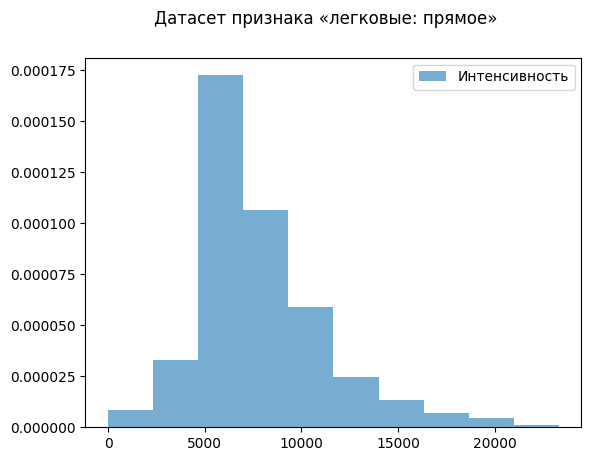

Близкое распределение к нашим данным: Бета-распределение


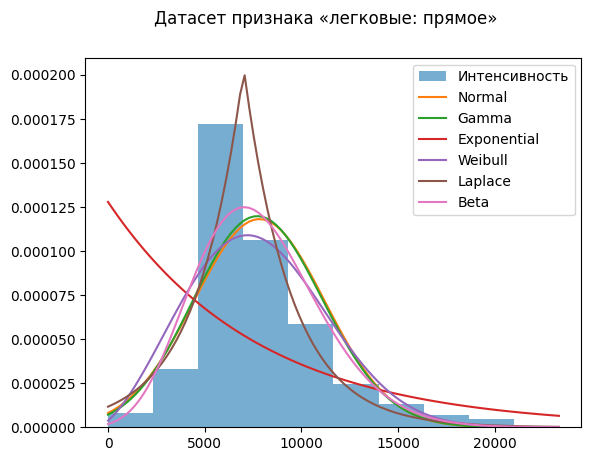

In [27]:
manager.get_distribution_laws(mtypes[0])

Анализируется датасет признака «легковые: обратное»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 1072.5130964229177
P-значение: 1.2786162725942045e-233

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 161.57102074054274
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.10504336034055384
P-значение: 1.6675856546928945e-21

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.35773255656126846
P-значение: 1.7065248320648889e-251

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.09119221770964353
P-значение: 2.63484463176842e-16

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуассона



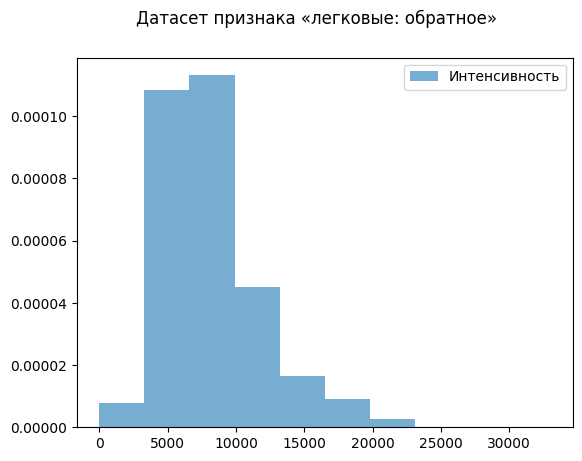

Близкое распределение к нашим данным: Бета-распределение


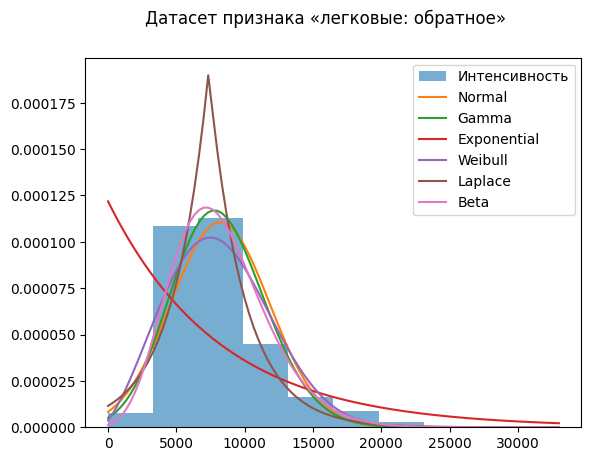

In [29]:
manager.get_distribution_laws(mtypes[1])

### 2) Микроавтобусы и малые грузовики

Анализируется датасет признака «микроавтобусы, малые грузовики: прямое»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 297.46469991761774
P-значение: 2.5489489195972264e-65

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 42.34187948900308
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.10844268541513713
P-значение: 6.809183530576851e-23

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.12963110099588715
P-значение: 1.4666208616155607e-32

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.08808480762524248
P-значение: 3.0587603309882455e-15

Выборка не соответствует распределению Вейбулла


Распределение соответствует зак

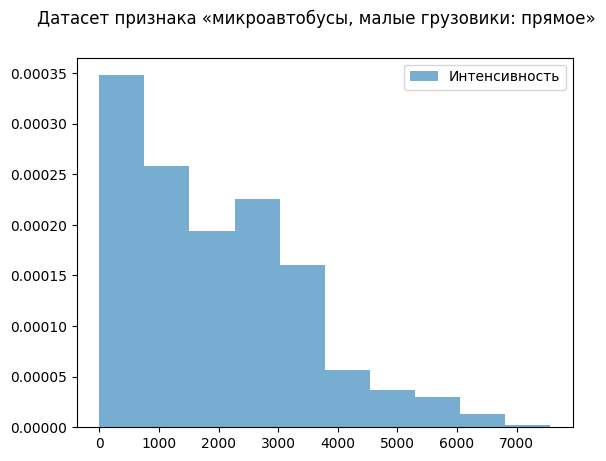

Близкое распределение к нашим данным: Бета-распределение


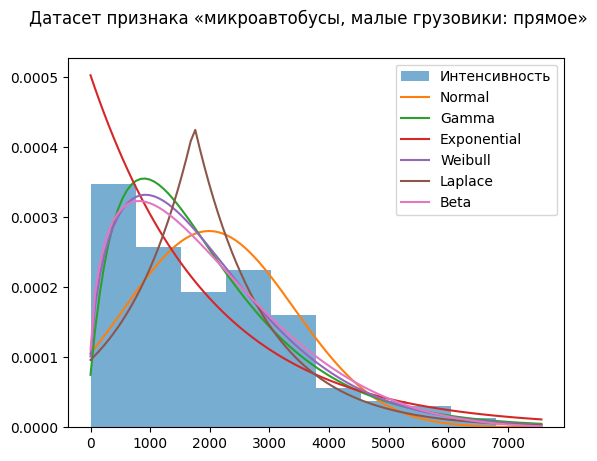

In [30]:
manager.get_distribution_laws(mtypes[2])

Анализируется датасет признака «микроавтобусы, малые грузовики: обратное»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 1506.9961967625331
P-значение: 0.0

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 33.533585426651825
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.10883802361394868
P-значение: 4.6629114367557945e-23

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.19466672162823512
P-значение: 3.2669638973741063e-73

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.05328137345356321
P-значение: 7.58694978068399e-06

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуассона



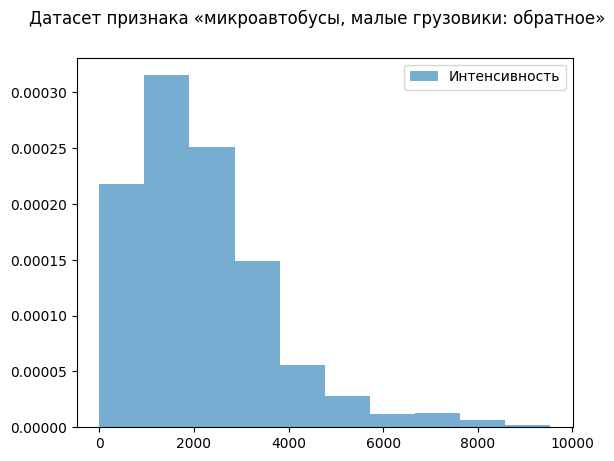

Близкое распределение к нашим данным: Бета-распределение


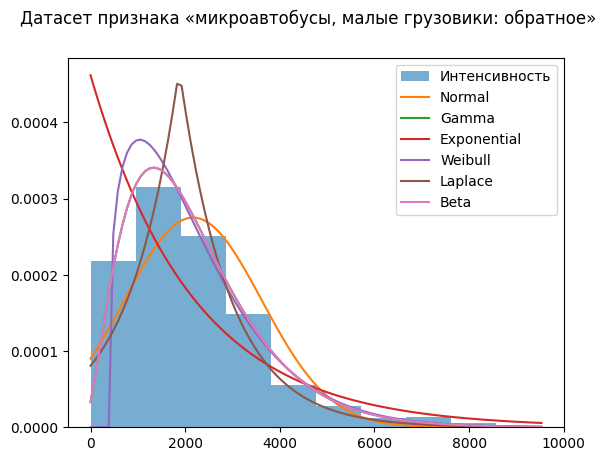

In [31]:
manager.get_distribution_laws(mtypes[3])

### 3) Одиночные АТС, автобусы

Анализируется датасет признака «одиночные АТС, автобусы: прямое»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 353.6590015363045
P-значение: 1.5992765846195142e-77

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 42.33634472133417
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.11462508491019818
P-значение: 1.5572622642783973e-25

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.18552652099898811
P-значение: 1.7334843920704616e-66

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.07934943117800225
P-значение: 1.905436887026263e-12

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуас

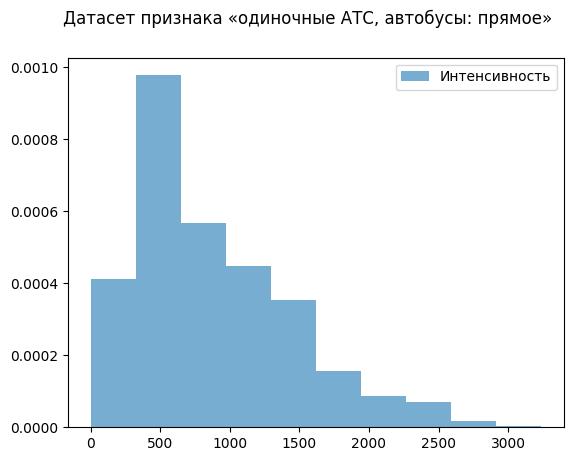

Близкое распределение к нашим данным: Гамма-распределение


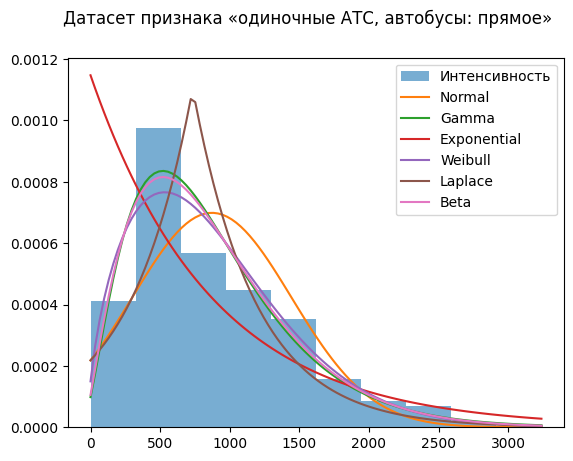

In [32]:
manager.get_distribution_laws(mtypes[4])

Анализируется датасет признака «одиночные АТС, автобусы: обратное»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 9588.209149332959
P-значение: 0.0

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 4671.027544584948
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.2578542629374856
P-значение: 5.828907577384263e-129

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.2389303684450731
P-значение: 1.5052769941493183e-110

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.18711246499983702
P-значение: 1.2474506738034834e-67

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуассона



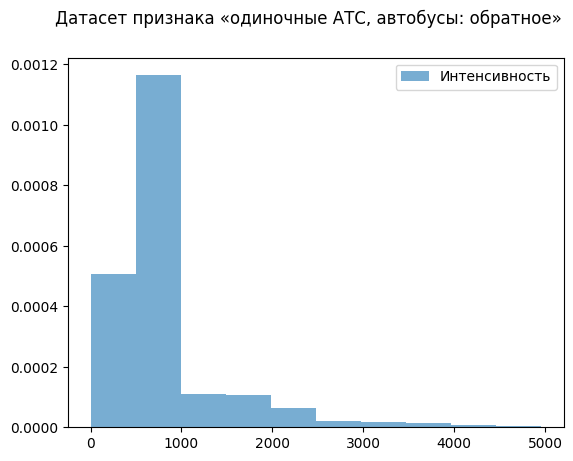

Близкое распределение к нашим данным: Распределение Лапласа


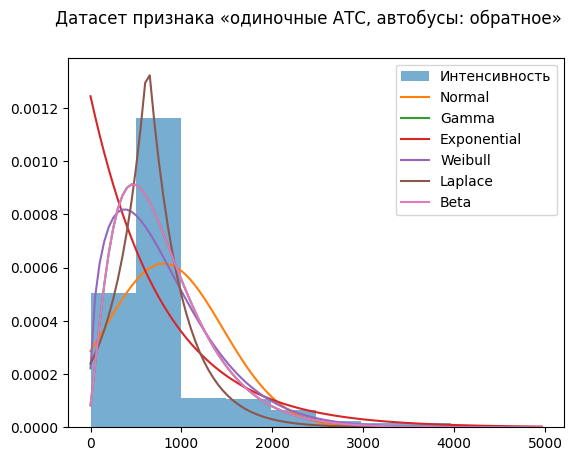

In [33]:
manager.get_distribution_laws(mtypes[5])

### 4) Автопоезда до 13 метров

Анализируется датасет признака «автопоезда до 13 м: прямое»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 158.0142653335058
P-значение: 4.871225694315378e-35

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 24.997606910021204
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.08035117578743123
P-значение: 9.427871622264616e-13

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.18864624558612741
P-значение: 9.57561653584773e-69

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.06315827310932104
P-значение: 4.846538591724269e-08

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуассона



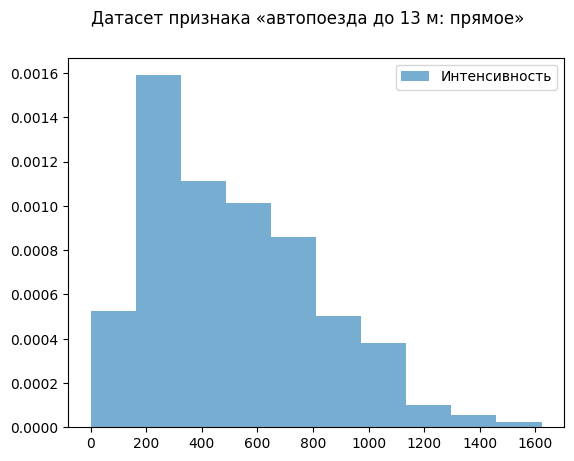

Близкое распределение к нашим данным: Бета-распределение


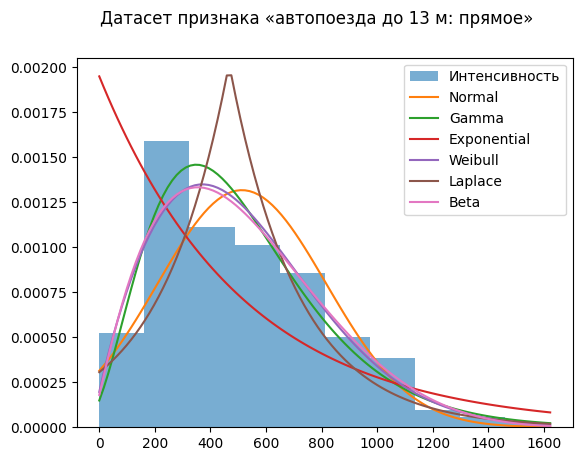

In [34]:
manager.get_distribution_laws(mtypes[6])

Анализируется датасет признака «автопоезда до 13 м: обратное»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 178.7727728337513
P-значение: 1.513511140025306e-39

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 34.48699194296205
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.11901729263721028
P-значение: 1.6840069677633227e-27

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.30176549638255773
P-значение: 1.7451771339165402e-177

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.0999807472533133
P-значение: 1.6143235507009787e-19

Выборка не соответствует распределению Вейбулла


Распределение не соответствует закону Пуас

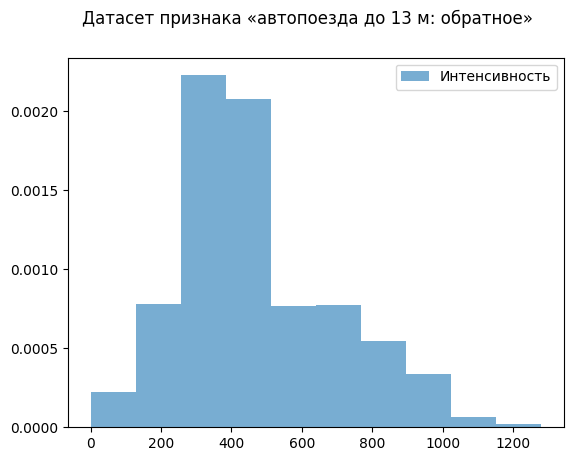

Близкое распределение к нашим данным: Бета-распределение


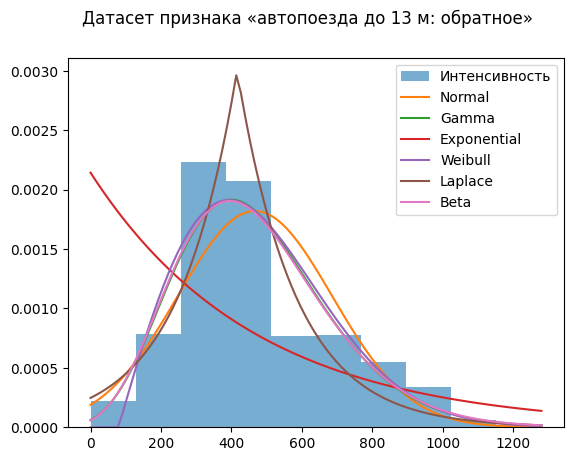

In [35]:
manager.get_distribution_laws(mtypes[7])

### 5) Автопоезда от 13 до 18 метров

Анализируется датасет признака «автопоезда 13..18  м: прямое»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 738.5939273757305
P-значение: 4.133962062111168e-161

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 71.23778033392864
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.14289201312750327
P-значение: 1.6897626716319098e-39

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.1494653204074624
P-значение: 3.417097996814457e-43

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.0658015836471717
P-значение: 1.0834354215619516e-08

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуассона


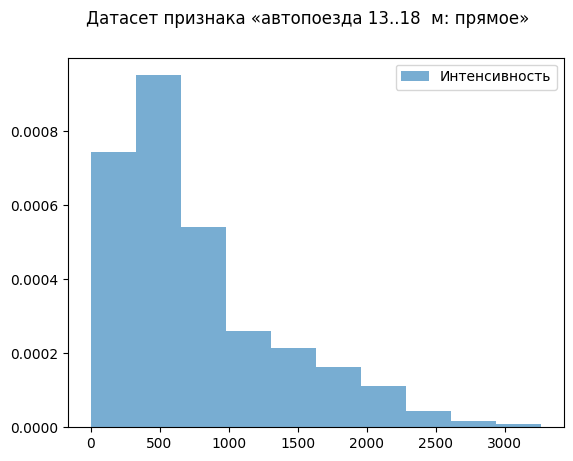

Близкое распределение к нашим данным: Бета-распределение


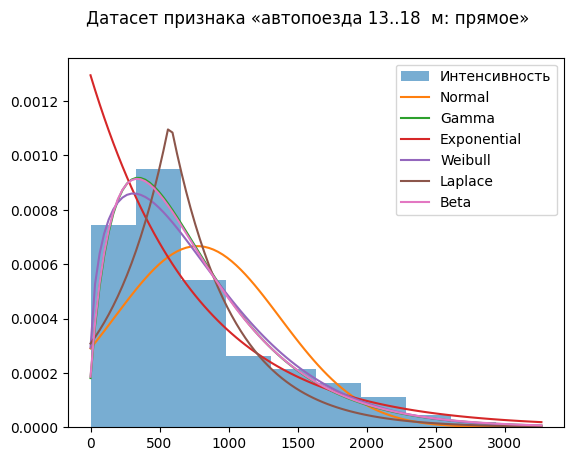

In [36]:
manager.get_distribution_laws(mtypes[8])

Анализируется датасет признака «автопоезда 13..18  м: обратное»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 112.93216822218959
P-значение: 2.9997927824215537e-25

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 24.939206015834316
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.09046707830081441
P-значение: 4.704956041966065e-16

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.2628133275716652
P-значение: 4.945452850007318e-134

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.06337551362133298
P-значение: 4.2950496137504903e-08

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуас

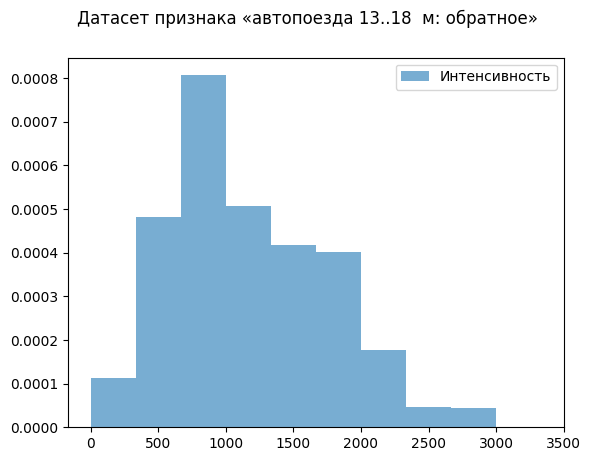

Близкое распределение к нашим данным: Гамма-распределение


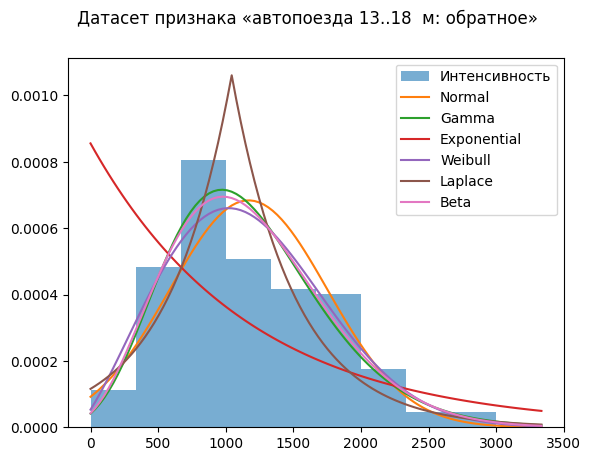

In [37]:
manager.get_distribution_laws(mtypes[9])

### 6) Автопоезда свыше 18 метров

Анализируется датасет признака «длинные автопоезда свыше 18 м: прямое»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 1682.5439086269992
P-значение: 0.0

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 148.272094262034
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.22058097059309795
P-значение: 4.184486693848294e-94

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.09282650108181267
P-значение: 7.011952780932859e-17

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.0704648952800695
P-значение: 6.633549130955223e-10

Выборка не соответствует распределению Вейбулла


Распределение соответствует закону Пуассона



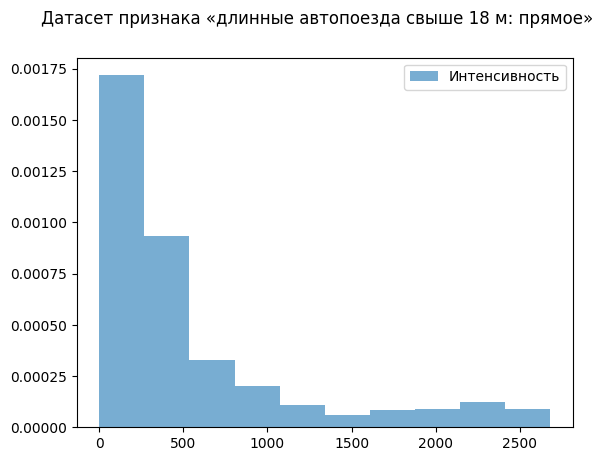

Близкое распределение к нашим данным: Распределение Вейбулла


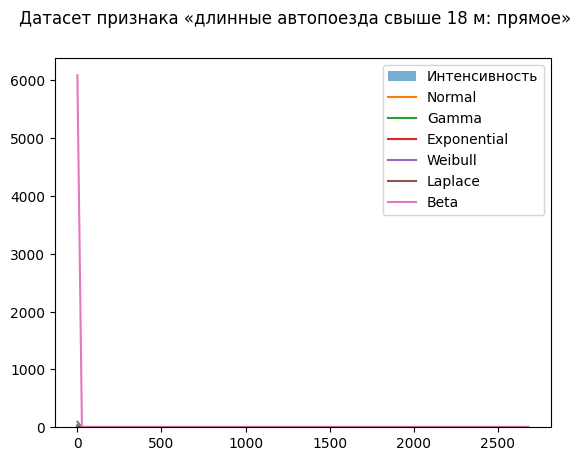

In [38]:
manager.get_distribution_laws(mtypes[10])

Анализируется датасет признака «длинные автопоезда свыше 18 м: обратное»...

Тест по критерию Харке-Бера на нормальность:

Статистика Харке-Бера: 67.4901917911701
P-значение: 2.2115209673295413e-15

Выборка не соответствует нормальному распределению

Тест по критерию Андерсона-Дарлинга на логистичность:

Статистика Андерсона-Дарлинга: 12.583728436485671
P-значение: 0.66

Выборка не соответствует логистическому распределению

Тест по критерию Колмогорова-Смирнова на нормальность и экспоненциальность, а также на распределение Вейбулла:

Статистика Колмогорова-Смирнова: 0.05045634120368381
P-значение: 2.749286474243829e-05

Выборка не соответствует нормальному распределению


Статистика Колмогорова-Смирнова: 0.22330967047458486
P-значение: 1.8340745437757234e-96

Выборка не соответствует экспоненциальному распределению


Статистика Колмогорова-Смирнова: 0.06855722817761223
P-значение: 2.128379567306489e-09

Выборка не соответствует распределению Вейбулла


Распределение соответствует зако

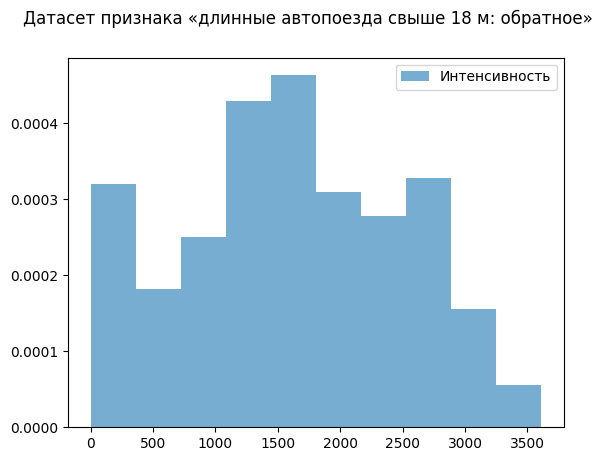

Близкое распределение к нашим данным: Распределение Вейбулла


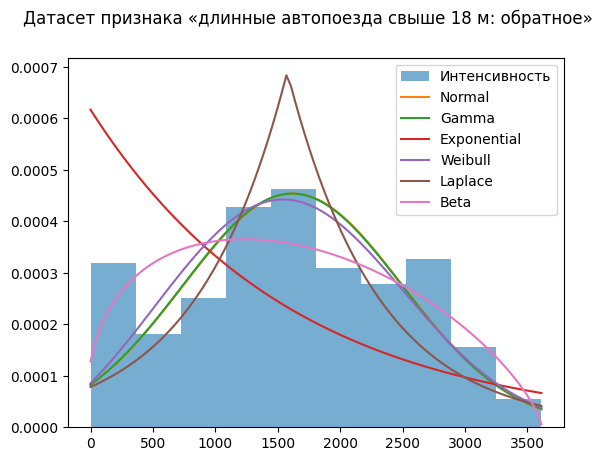

In [39]:
manager.get_distribution_laws(mtypes[11])

## Задание № 2

In [76]:
real_dt

легковые: всего  легковые: прямое  легковые: обратное  \
deta                                                                
2017-01-01             9593              6196                3397   
2017-01-02            12555              6455                6100   
2017-01-03            13139              6815                6324   
2017-01-04            20273             11667                8606   
2017-01-05                0                 0                   0   
...                     ...               ...                 ...   
2022-12-27            11665              6141                5524   
2022-12-28            13500              7663                5837   
2022-12-29            14673              8358                6315   
2022-12-30            21564             15348                6216   
2022-12-31            14375             10502                3873   

            микроавтобусы, малые грузовики: всего  \
deta                                                
2017-01-01                                    508   
2017-01-02                                   1555   
2017-01-03                                   1720   
2017-01-04                                   2292   
2017-01-05                                      0   
...                                           ...   
2022-12-27                                   4859   
2022-12-28                                   5512   
2022-12-29                                   4209   
2022-12-30                                   6486   
2022-12-31                                   3152   

            микроавтобусы, малые грузовики: прямое  \
deta                                                 
2017-01-01                                     344   
2017-01-02                                     803   
2017-01-03                                     840   
2017-01-04                                    1453   
2017-01-05                                       0   
...                                            ...   
2022-12-27                                    3039   
2022-12-28                                    3720   
2022-12-29                                    2783   
2022-12-30                                    5063   
2022-12-31                                    2414   

            микроавтобусы, малые грузовики: обратное  \
deta                                                   
2017-01-01                                       164   
2017-01-02                                       752   
2017-01-03                                       880   
2017-01-04                                       839   
2017-01-05                                         0   
...                                              ...   
2022-12-27                                      1820   
2022-12-28                                      1792   
2022-12-29                                      1426   
2022-12-30                                      1423   
2022-12-31                                       738   

            одиночные АТС, автобусы: всего  одиночные АТС, автобусы: прямое  \
deta                                                                          
2017-01-01                              82                               44   
2017-01-02                             834                              392   
2017-01-03                             992                              506   
2017-01-04                             860                              455   
2017-01-05                               0                                0   
...                                    ...                              ...   
2022-12-27                            2291                             1565   
2022-12-28                            2301                             1695   
2022-12-29                            1455                              939   
2022-12-30                            2106                             1677   
2022-12-31                             709  

### Обучение нейросетевой модели

In [112]:
manager = ModelManager(real_dt)

In [113]:
manager.train_models()

Модель признака «легковые: прямое» успешно обучена!
Первый Train Loss = 4.268256605793528, финальный Train Loss = 0.006811578547145323

Модель признака «легковые: обратное» успешно обучена!
Первый Train Loss = 6.507303363040591, финальный Train Loss = 0.0016907791341976377

Модель признака «микроавтобусы, малые грузовики: прямое» успешно обучена!
Первый Train Loss = 3.566454211168131, финальный Train Loss = 0.0005641427046220369

Модель признака «микроавтобусы, малые грузовики: обратное» успешно обучена!
Первый Train Loss = 4.164473991154672, финальный Train Loss = 0.0016458862962140672

Модель признака «одиночные АТС, автобусы: прямое» успешно обучена!
Первый Train Loss = 3.5363320210832767, финальный Train Loss = 0.004168029689680014

Модель признака «одиночные АТС, автобусы: обратное» успешно обучена!
Первый Train Loss = 4.313242431919165, финальный Train Loss = 0.008130517539064066

Модель признака «автопоезда до 13 м: прямое» успешно обучена!
Первый Train Loss = 6.379445434500678,

In [114]:
[elem for elem in real_dt.columns[:18] if not elem.endswith('всего')]

['легковые: прямое',
 'легковые: обратное',
 'микроавтобусы, малые грузовики: прямое',
 'микроавтобусы, малые грузовики: обратное',
 'одиночные АТС, автобусы: прямое',
 'одиночные АТС, автобусы: обратное',
 'автопоезда до 13 м: прямое',
 'автопоезда до 13 м: обратное',
 'автопоезда 13..18  м: прямое',
 'автопоезда 13..18  м: обратное',
 'длинные автопоезда свыше 18 м: прямое',
 'длинные автопоезда свыше 18 м: обратное']

In [115]:
mtypes = [elem for elem in real_dt.columns[:18] if not elem.endswith('всего')]
models = manager.get_models(mtypes)
models

#### Пример обучения на легковых авто

In [40]:
passer_car_17_22

легковые: всего  легковые: прямое  легковые: обратное        time  \
deta                                                                            
2017-01-01             9593              6196                3397  14832288.0   
2017-01-02            12555              6455                6100  14833152.0   
2017-01-03            13139              6815                6324  14834016.0   
2017-01-04            20273             11667                8606  14834880.0   
2017-01-05                0                 0                   0  14835744.0   
...                     ...               ...                 ...         ...   
2022-12-27            11665              6141                5524  16720992.0   
2022-12-28            13500              7663                5837  16721856.0   
2022-12-29            14673              8358                6315  16722720.0   
2022-12-30            21564             15348                6216  16723584.0   
2022-12-31            14375             10502                3873  16724448.0   

            month:1  month:2  month:3  month:4  month:5  month:6  ...  \
deta                                                              ...   
2017-01-01        1        0        0        0        0        0  ...   
2017-01-02        1        0        0        0        0        0  ...   
2017-01-03        1        0        0        0        0        0  ...   
2017-01-04        1        0        0        0        0        0  ...   
2017-01-05        1        0        0        0        0        0  ...   
...             ...      ...      ...      ...      ...      ...  ...   
2022-12-27        0        0        0        0        0        0  ...   
2022-12-28        0        0        0        0        0        0  ...   
2022-12-29        0        0        0        0        0        0  ...   
2022-12-30        0        0        0        0        0        0  ...   
2022-12-31        0        0        0        0        0        0  ...   

            weekday:4  weekday:5  weekday:6  weekday:7  2017  2018  2019  \
deta                                                                       
2017-01-01          0          0          0          1     1     0     0   
2017-01-02          0          0          0          0     1     0     0   
2017-01-03          0          0          0          0     1     0     0   
2017-01-04          0          0          0          0     1     0     0   
2017-01-05          1          0          0          0     1     0     0   
...               ...        ...        ...        ...   ...   ...   ...   
2022-12-27          0          0          0          0     0     0     0   
2022-12-28          0          0          0          0     0     0     0   
2022-12-29          1          0          0          0     0     0     0   
2022-12-30          0          1          0          0     0     0     0   
2022-12-31          0          0          1          0     0     0     0   

            2020  2021  2022  
deta                          
2017-01-01     0     0     0  
2017-01-02     0     0     0  
2017-01-03     0     0     0  
2017-01-04     0     0     0  
2017-01-05     0     0     0  
...          ...   ...   ...  
2022-12-27     0     0     1  
2022-12-28     0     0     1  
2022-12-29     0     0     1  
2022-12-30     0     0     1  
2022-12-31     0     0     1  

[2191 rows x 60 columns]

In [41]:
passenger_cars_dataset = Dataset_roads(passer_car_17_22, "легковые: прямое")

In [42]:
train, test = torch.utils.data.random_split(passenger_cars_dataset, [0.8, 0.2])
data_train_loader = DataLoader(train, batch_size=100, shuffle=True)
data_test_loader = DataLoader(test, batch_size=100, shuffle=False)
len(train.indices), len(test.indices)

(1753, 438)

In [43]:
passenger_cars_dataset.X

tensor([[-1.7309,  3.2825, -0.2890,  ..., -0.4082, -0.4082,  2.4489],
        [-1.7293,  3.2825, -0.2890,  ..., -0.4082, -0.4082, -0.4082],
        [-1.7277,  3.2825, -0.2890,  ..., -0.4082, -0.4082, -0.4082],
        ...,
        [ 1.7277, -0.3045, -0.2890,  ..., -0.4082, -0.4082, -0.4082],
        [ 1.7293, -0.3045, -0.2890,  ...,  2.4489, -0.4082, -0.4082],
        [ 1.7309, -0.3045, -0.2890,  ..., -0.4082,  2.4489, -0.4082]])

In [44]:
passenger_cars_dataset.y

tensor([[-0.4817],
        [-0.4051],
        [-0.2985],
        ...,
        [ 0.1581],
        [ 2.2266],
        [ 0.7925]])

In [45]:
def predict(net, X, y, indexes, passenger_cars_1):
    y_pred = net.forward(X)
    Yt = y.view(1, -1).numpy()[0]
    Pr = torch.tensor(y_pred.view(1, -1)[0]).numpy()
    result = pd.DataFrame(
        {
            "Test Value": Yt,
            "Prediction": Pr
         }
      )
    result.index = (indexes)
    fig = px.line(result)
    fig.show()

def predict_normalize(net, X, y, passenger_cars_1):
    y_pred = net.forward(X)
    Yt = y.view(1, -1).numpy()[0]
    Pr = torch.tensor(y_pred.view(1, -1)[0]).numpy()
    result = pd.DataFrame(
        {
            "TestY": (Yt * passenger_cars_1.Y_std.numpy()) + passenger_cars_1.Y_mean.numpy(),
            "Prediction": (Pr * passenger_cars_1.Y_std.numpy()) + passenger_cars_1.Y_mean.numpy()
         }
      )
    fig = px.line(result)
    fig.show()

In [46]:
n1 = 100
n2 = 100
n3 = 125

model = torch.nn.Sequential(
    nn.Linear(51, n1),
    nn.LayerNorm(n1),
    nn.Softmax(),
    nn.Linear(n1, n2),
    nn.LayerNorm(n2),
    nn.ReLU(),
    nn.Linear(n2, n3),
    nn.LayerNorm(n3),
    nn.LeakyReLU(),
    nn.Linear(n3, 1),
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.04)
criterion = nn.MSELoss(reduction='sum')

print(len(train.indices), len(test.indices))

train_losses = []
for epoch_index in range(1000):
  train_loss = 0
  for X, y in data_train_loader:
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    
    y_pred = model(X)
    loss_val = criterion(y_pred, y)

    loss_val.backward()
    optimizer.step()

    train_loss += loss_val.item()

  train_loss /= len(data_train_loader.dataset)
  train_losses.append(train_loss)
  
  print(f'Epoch {epoch_index + 1}, Loss value: {train_losses[-1]}')

1753 438
Epoch 1, Loss value: 1.7903597168560648
Epoch 2, Loss value: 0.8004597567587122
Epoch 3, Loss value: 0.6880869389396358
Epoch 4, Loss value: 0.5892585617300448
Epoch 5, Loss value: 0.5490317945812201
Epoch 6, Loss value: 0.5086371905451424
Epoch 7, Loss value: 0.46110624758366237
Epoch 8, Loss value: 0.4383460696057735
Epoch 9, Loss value: 0.4219999536404389
Epoch 10, Loss value: 0.4165708658291283
Epoch 11, Loss value: 0.4023037027510247
Epoch 12, Loss value: 0.3712147344403177
Epoch 13, Loss value: 0.2957766152625076
Epoch 14, Loss value: 0.2652549286672067
Epoch 15, Loss value: 0.2664954157740609
Epoch 16, Loss value: 0.2640868196199094
Epoch 17, Loss value: 0.2390478561758247
Epoch 18, Loss value: 0.22404716848579054
Epoch 19, Loss value: 0.21547641090440942
Epoch 20, Loss value: 0.1948164299563959
Epoch 21, Loss value: 0.220418446416251
Epoch 22, Loss value: 0.20836102180459196
Epoch 23, Loss value: 0.1746808382285641
Epoch 24, Loss value: 0.17936397890873249
Epoch 25, Lo

##### График функции ошибки

In [47]:
results_loss = pd.DataFrame({'Train Loss': train_losses})
fig = px.line(results_loss)
fig.show()

##### Результирующие графики

In [48]:
predict(model, passenger_cars_dataset.X.float(), passenger_cars_dataset.y.float(), real_dt['deta'], passenger_cars_dataset)

In [49]:
predict_normalize(model, test.dataset[test.indices][0].float(), test.dataset[test.indices][1].float(), passenger_cars_dataset)

##### Проверка на тестовом множестве

In [50]:
model.to(device)
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in data_test_loader:
      X_ = X.to(device)
      y_ = y.to(device)

      y_pred_value = model(X_)

      y_true.extend(y_.detach().cpu().tolist())
      y_pred.extend(y_pred_value.detach().cpu().tolist())

r2 = r2_score(y_true, y_pred)
MAE = mean_absolute_error(y_true, y_pred)
MAPE = mean_absolute_percentage_error(y_true, y_pred)
MSE = mean_squared_error(y_true, y_pred)
MEDAE = median_absolute_error(y_true, y_pred)

print(f'Test R2: {r2}')
print(f'Test Mean Absolute Error: {MAE}')
print(f'Test Mean Absolute Percentage Error: {round(MAPE, 4)}%')
print(f'Test Mean Squared Error: {MSE}')
print(f'Test Median Absolute Error: {MEDAE}')

results_loss = pd.DataFrame({'True Value': sum(y_true, []), 'Prediction': sum(y_pred, [])})
fig = px.line(results_loss)
fig.show()

Test R2: 0.14235626659705547
Test Mean Absolute Error: 0.6515854898947567
Test Mean Absolute Percentage Error: 2.7293%
Test Mean Squared Error: 0.8522531228763331
Test Median Absolute Error: 0.4515593647956848


#### Результаты обучения остальных моделей

Проверка на тестовом множестве всех категорий транспорта, по которым успели обучиться модели

In [116]:
manager.test_predict(mtypes[0])

Test R2: 0.019143193513918022
Test Mean Absolute Error: 0.7416915188875203
Test Mean Absolute Percentage Error: 2.3337%
Test Mean Squared Error: 1.0778295223845427
Test Median Absolute Error: 0.5290910452604294


In [117]:
manager.test_predict(mtypes[1])

Test R2: -0.21138914498127215
Test Mean Absolute Error: 0.7637266331048896
Test Mean Absolute Percentage Error: 8.0234%
Test Mean Squared Error: 1.1073164629804035
Test Median Absolute Error: 0.5508829355239868


In [118]:
manager.test_predict(mtypes[2])

Test R2: 0.12479334864792324
Test Mean Absolute Error: 0.6426297419456449
Test Mean Absolute Percentage Error: 4.7597%
Test Mean Squared Error: 0.7794277737283775
Test Median Absolute Error: 0.46949532628059387


In [119]:
manager.test_predict(mtypes[3])

Test R2: -0.292765207587516
Test Mean Absolute Error: 0.755166321563493
Test Mean Absolute Percentage Error: 5.052%
Test Mean Squared Error: 1.1175618131644172
Test Median Absolute Error: 0.545717790722847


In [120]:
manager.test_predict(mtypes[4])

Test R2: -0.1321360782863794
Test Mean Absolute Error: 0.7691375371908608
Test Mean Absolute Percentage Error: 2.0818%
Test Mean Squared Error: 1.1066938864003917
Test Median Absolute Error: 0.5273461937904358


In [121]:
manager.test_predict(mtypes[5])

Test R2: 0.08185606358555098
Test Mean Absolute Error: 0.5500656178701652
Test Mean Absolute Percentage Error: 1.5405%
Test Mean Squared Error: 0.9278178895111188
Test Median Absolute Error: 0.2273106426000595


In [122]:
manager.test_predict(mtypes[6])

Test R2: -0.40988552890562
Test Mean Absolute Error: 0.905847313418372
Test Mean Absolute Percentage Error: 2.968%
Test Mean Squared Error: 1.3840481069358612
Test Median Absolute Error: 0.7166455090045929


In [123]:
manager.test_predict(mtypes[7])

Test R2: -0.03672073218171468
Test Mean Absolute Error: 0.760023146029987
Test Mean Absolute Percentage Error: 2.1862%
Test Mean Squared Error: 1.0924383964356608
Test Median Absolute Error: 0.5315069369971752


In [124]:
manager.test_predict(mtypes[8])

Test R2: 0.045125835101841316
Test Mean Absolute Error: 0.7003504965288488
Test Mean Absolute Percentage Error: 2.1458%
Test Mean Squared Error: 0.9835429268680042
Test Median Absolute Error: 0.4536619260907173


In [125]:
manager.test_predict(mtypes[9])

Test R2: 0.20581929714730218
Test Mean Absolute Error: 0.622724350914997
Test Mean Absolute Percentage Error: 2.5863%
Test Mean Squared Error: 0.8203265918737231
Test Median Absolute Error: 0.42274300195276737


In [126]:
manager.test_predict(mtypes[10])

Test R2: -0.23522841622254642
Test Mean Absolute Error: 0.6943145553686669
Test Mean Absolute Percentage Error: 2.4487%
Test Mean Squared Error: 1.180092711906745
Test Median Absolute Error: 0.3069252036511898


In [127]:
manager.test_predict(mtypes[11])

Test R2: 0.7329143116120875
Test Mean Absolute Error: 0.3920713281705465
Test Mean Absolute Percentage Error: 2.0641%
Test Mean Squared Error: 0.2836671870370495
Test Median Absolute Error: 0.2687062919139862


## Предсказание интенсивности на следующие 10 лет

#### Пример предсказания на легковых авто

##### Генерация датасета

In [64]:
start = real_dt.iloc[-1]["deta"] + pd.Timedelta("1 day")
predict_years = 10
start

Timestamp('2023-01-01 00:00:00')

In [65]:
end = pd.to_datetime(datetime.datetime(start.year + predict_years, 1, 1)) + pd.Timedelta("-1 day")
end

Timestamp('2032-12-31 00:00:00')

In [66]:
index = pd.date_range(start, end)
df_pred = pd.DataFrame({"deta": index})

dti = pd.date_range(real_dt.iloc[-1]["deta"], periods=3, freq="Y")
df_pred = df_pred.set_index("deta")

df_pred["deta"] = df_pred.index
df_pred["time"] = df_pred.index
df_pred["time"] = df_pred["time"].apply(lambda x: x.value / 10**11 )
df_pred["Month"] = df_pred['deta'].apply(lambda x: x.month)
df_pred["Day"] = df_pred['deta'].apply(lambda x: x.day)
df_pred["Weekday"] = df_pred['deta'].apply(lambda x: x.isoweekday())

df_pred

deta        time  Month  Day  Weekday
deta                                                  
2023-01-01 2023-01-01  16725312.0      1    1        7
2023-01-02 2023-01-02  16726176.0      1    2        1
2023-01-03 2023-01-03  16727040.0      1    3        2
2023-01-04 2023-01-04  16727904.0      1    4        3
2023-01-05 2023-01-05  16728768.0      1    5        4
...               ...         ...    ...  ...      ...
2032-12-27 2032-12-27  19877184.0     12   27        1
2032-12-28 2032-12-28  19878048.0     12   28        2
2032-12-29 2032-12-29  19878912.0     12   29        3
2032-12-30 2032-12-30  19879776.0     12   30        4
2032-12-31 2032-12-31  19880640.0     12   31        5

[3653 rows x 5 columns]

##### Формирование one hot encoding

In [67]:
d = {"Month": "month:{}", "Day": "day:{}", "Weekday": "weekday:{}"}
du = []
for k, v in d.items():
  s = df_pred[k]
  du.append(pd.get_dummies(s))
  du[-1] = du[-1].rename({i+1: v.format(i+1) for i in range(du[-1].shape[1])}, axis=1)
for i in du:
  df_pred = df_pred.join(i)

df_pred

deta        time  Month  Day  Weekday  month:1  month:2  \
deta                                                                       
2023-01-01 2023-01-01  16725312.0      1    1        7        1        0   
2023-01-02 2023-01-02  16726176.0      1    2        1        1        0   
2023-01-03 2023-01-03  16727040.0      1    3        2        1        0   
2023-01-04 2023-01-04  16727904.0      1    4        3        1        0   
2023-01-05 2023-01-05  16728768.0      1    5        4        1        0   
...               ...         ...    ...  ...      ...      ...      ...   
2032-12-27 2032-12-27  19877184.0     12   27        1        0        0   
2032-12-28 2032-12-28  19878048.0     12   28        2        0        0   
2032-12-29 2032-12-29  19878912.0     12   29        3        0        0   
2032-12-30 2032-12-30  19879776.0     12   30        4        0        0   
2032-12-31 2032-12-31  19880640.0     12   31        5        0        0   

            month:3  month:4  month:5  ...  day:29  day:30  day:31  weekday:1  \
deta                                   ...                                      
2023-01-01        0        0        0  ...       0       0       0          0   
2023-01-02        0        0        0  ...       0       0       0          1   
2023-01-03        0        0        0  ...       0       0       0          0   
2023-01-04        0        0        0  ...       0       0       0          0   
2023-01-05        0        0        0  ...       0       0       0          0   
...             ...      ...      ...  ...     ...     ...     ...        ...   
2032-12-27        0        0        0  ...       0       0       0          1   
2032-12-28        0        0        0  ...       0       0       0          0   
2032-12-29        0        0        0  ...       1       0       0          0   
2032-12-30        0        0        0  ...       0       1       0          0   
2032-12-31        0        0        0  ...       0       0       1          0   

            weekday:2  weekday:3  weekday:4  weekday:5  weekday:6  weekday:7  
deta                                                                          
2023-01-01          0          0          0          0          0          1  
2023-01-02          0          0          0          0          0          0  
2023-01-03          1          0          0          0          0          0  
2023-01-04          0          1          0          0          0          0  
2023-01-05          0          0          1          0          0          0  
...               ...        ...        ...        ...        ...        ...  
2032-12-27          0          0          0          0          0          0  
2032-12-28          1          0          0          0          0          0  
2032-12-29          0          1          0          0          0          0  
2032-12-30          0          0          1          0          0          0  
2032-12-31          0          0          0          1          0          0  

[3653 rows x 55 columns]

##### Предсказание данных

In [68]:
roads_predict_data = Dataset_roads_predict(df_pred, passenger_cars_dataset.X_mean, passenger_cars_dataset.X_std)
print(roads_predict_data)

In [69]:
def predict_future(net, X, Y_mean, Y_std, indexes):
    y_pred = net.forward(X)
    Pr = torch.tensor(y_pred.view(1, -1)[0]).numpy()
    result = pd.DataFrame(
        {
            "Prediction": (Pr * Y_std.numpy()) + Y_mean.numpy()
         }
      )
    result.index = indexes
    fig = px.line(result)
    fig.show()

    return result

pred_dataset = predict_future(model, roads_predict_data.X.float(), passenger_cars_dataset.Y_mean, passenger_cars_dataset.Y_std, df_pred.index)

In [70]:
results_all = pd.DataFrame({'Input Data': real_dt['легковые: прямое'], 'Output Data': pred_dataset['Prediction']})
results_all.index = real_dt.index.append(pred_dataset.index)
fig = px.line(results_all)
fig.show()

#### Результаты предсказания остальных моделей

In [140]:
manager.make_prediction(mtypes[0])

Prediction
2023-01-01      8709.0
2023-01-02      8709.0
2023-01-03      8709.0
2023-01-04      8709.0
2023-01-05      8709.0
...                ...
2032-12-27      8709.0
2032-12-28      8709.0
2032-12-29      8709.0
2032-12-30      8709.0
2032-12-31      8709.0

[3653 rows x 1 columns]

In [129]:
manager.all_prediction()

легковые: прямое  легковые: обратное  \
2023-01-01            8709.0              9573.0   
2023-01-02            8709.0              9573.0   
2023-01-03            8709.0              9573.0   
2023-01-04            8709.0              9573.0   
2023-01-05            8709.0              9573.0   
...                      ...                 ...   
2032-12-27            8709.0              9573.0   
2032-12-28            8709.0              9573.0   
2032-12-29            8709.0              9573.0   
2032-12-30            8709.0              9573.0   
2032-12-31            8709.0              9573.0   

            микроавтобусы, малые грузовики: прямое  \
2023-01-01                                  2170.0   
2023-01-02                                  2170.0   
2023-01-03                                  2170.0   
2023-01-04                                  2170.0   
2023-01-05                                  2170.0   
...                                            ...   
2032-12-27                                  2170.0   
2032-12-28                                  2170.0   
2032-12-29                                  2170.0   
2032-12-30                                  2170.0   
2032-12-31                                  2170.0   

            микроавтобусы, малые грузовики: обратное  \
2023-01-01                                    2576.0   
2023-01-02                                    2576.0   
2023-01-03                                    2576.0   
2023-01-04                                    2576.0   
2023-01-05                                    2576.0   
...                                              ...   
2032-12-27                                    2576.0   
2032-12-28                                    2576.0   
2032-12-29                                    2576.0   
2032-12-30                                    2576.0   
2032-12-31                                    2576.0   

            одиночные АТС, автобусы: прямое  \
2023-01-01                           1363.0   
2023-01-02                           1363.0   
2023-01-03                           1363.0   
2023-01-04                           1363.0   
2023-01-05                           1363.0   
...                                     ...   
2032-12-27                           1363.0   
2032-12-28                           1363.0   
2032-12-29                           1363.0   
2032-12-30                           1363.0   
2032-12-31                           1363.0   

            одиночные АТС, автобусы: обратное  автопоезда до 13 м: прямое  \
2023-01-01                              654.0                       503.0   
2023-01-02                              654.0                       503.0   
2023-01-03                              654.0                       503.0   
2023-01-04                              654.0                       503.0   
2023-01-05                              654.0                       503.0   
...                                       ...                         ...   
2032-12-27                              654.0                       503.0   
2032-12-28                              654.0                       503.0   
2032-12-29                              654.0                       503.0   
2032-12-30                              654.0                       503.0   
2032-12-31                              654.0                       503.0   

            автопоезда до 13 м: обратное  автопоезда 13..18  м: прямое  \
2023-01-01                         483.0                         674.0   
2023-01-02                         483.0                         674.0   
2023-01-03                         483.0                         674.0   
2023-01-04                         483.0                         674.0   
2023-01-05                         483.0                         674.0   
...                                  ...                           ...   
2032-12-27                         483.0                 

## Задание № 3

### Расчёт продольной ровности дороги

In [141]:
PATH = '/content/gdrive/MyDrive/Мои_файлы/3_курсовая'

iri = pd.read_excel(PATH + "/IRI.xlsx", header=None, skiprows=5)

names=["Начало участка", "Конец участка", "Прямое напр(1)", "Прямое напр(2)",
       "Обратное напр(1)", "Обратное напр(2)", "Прибор", "Нормальное знач"]

iri.columns=names
iri

Начало участка  Конец участка  Прямое напр(1)  Прямое напр(2)  \
0              84.0           84.1            1.90            1.99   
1              84.1           84.2            1.85            1.88   
2              84.2           84.3            1.88            1.94   
3              84.3           84.4            1.79            1.90   
4              84.4           84.5            1.69            1.94   
..              ...            ...             ...             ...   
105            94.5           94.6            1.32            1.52   
106            94.6           94.7            1.20            1.53   
107            94.7           94.8            1.39            1.56   
108            94.8           94.9            1.35            1.52   
109            94.9           95.0            2.15            1.88   

     Обратное напр(1)  Обратное напр(2)       Прибор  Нормальное знач  
0                1.91              2.19  профилометр              2.2  
1                1.63              2.20  профилометр              2.2  
2                1.37              1.64  профилометр              2.2  
3                1.11              1.64  профилометр              2.2  
4                1.11              1.44  профилометр              2.2  
..                ...               ...          ...              ...  
105              1.17              1.62  профилометр              2.2  
106              1.58              1.70  профилометр              2.2  
107              1.64              1.46  профилометр              2.2  
108              1.54              1.54  профилометр              2.2  
109              1.25              1.31  профилометр              2.2  

[110 rows x 8 columns]

In [142]:
mm = ModelManager(real_dt)
prediction_all = manager.all_prediction()
mm.forecast_road_roughness(prediction_all, PATH + "/IRI.xlsx")

IsADirectoryError: ignored

#### Диаграммы распределения IRI по всем полосам дороги

In [ ]:
pryamoe1 = iri["Прямое напр(1)"]
pryamoe1 = pryamoe1.sort_values(ascending=False).to_frame()
pryamoe1["Номер"] = list(range(1, iri.shape[0] + 1))

pryamoe1[:40].plot(x="Номер", y="Прямое напр(1)",
                   kind="bar", title="Ранжированный ряд по полосе 1, прямое направление",
                   ylabel="Величина IRI м/км", xlabel="Порядковый номер ряда")

pryamoe1 = pryamoe1.set_index("Номер")

In [ ]:
pryamoe2 = iri["Прямое напр(2)"]
pryamoe2 = pryamoe2.sort_values(ascending=False).to_frame()
pryamoe2["Номер"] = list(range(1, iri.shape[0] + 1))

pryamoe2[:40].plot(x="Номер", y="Прямое напр(2)",
                   kind="bar", title="Ранжированный ряд по полосе 2, прямое направление",
                   ylabel="Величина IRI м/км", xlabel="Порядковый номер ряда")

pryamoe2 = pryamoe2.set_index("Номер")

In [ ]:
obratnoe1 = iri["Обратное напр(1)"]
obratnoe1 = obratnoe1.sort_values(ascending=False).to_frame()
obratnoe1["Номер"] = list(range(1, iri.shape[0] + 1))

obratnoe1[:40].plot(x="Номер", y="Обратное напр(1)",
                    kind="bar", title="Ранжированный ряд по полосе 1, Обратное направление",
                    ylabel="Величина IRI м/км", xlabel="Порядковый номер ряда")

obratnoe1 = obratnoe1.set_index("Номер")

In [ ]:
obratnoe2 = iri["Обратное напр(2)"]
obratnoe2 = obratnoe2.sort_values(ascending=False).to_frame()
obratnoe2["Номер"] = list(range(1, iri.shape[0] + 1))

obratnoe2[:40].plot(x="Номер", y="Обратное напр(2)",
                    kind="bar", title="Ранжированный ряд по полосе 1, Обратное направление",
                    ylabel="Величина IRI м/км", xlabel="Порядковый номер ряда")

obratnoe2 = obratnoe2.set_index("Номер")

In [ ]:
print(f"r(недоп) — {rNeDop}, n(порядковый номер измерения) — {n}")

In [ ]:
IRI_f1 = pryamoe1["Прямое напр(1)"][n]
IRI_f2 = pryamoe2["Прямое напр(2)"][n]
IRI_f3 = obratnoe1["Обратное напр(1)"][n]
IRI_f4 = obratnoe2["Обратное напр(2)"][n]

print(f"IRIф по полосе 1, прямое направление = {IRI_f1}\n\nIRIф по полосе 2, прямое направление = {IRI_f2}")
print(f"IRIф по полосе 1, обратное направление = {IRI_f3}\n\nIRIф по полосе 2, обратное направление = {IRI_f4}")